In [1]:
# Importlibrairies 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report , confusion_matrix
from scipy import stats


### 1- Découverte du jeu de données
### 2- Organisation des colonnes et des lignes
### 3- Gestion des valeurs aberrantes
### 4- Imputation des valeurs manquantes

In [2]:
#Download file
df=pd.read_csv("fr.openfoodfacts.org.products.csv",sep='\t',low_memory=False)

In [3]:
#Display options
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', 1)
pd.set_option("display.colheader_justify","right")
pd.options.display.max_info_columns=200


In [4]:
#Display file
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_fr,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_fr,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_fr,ingredients_text,allergens,allergens_fr,traces,traces_tags,traces_fr,serving_size,no_nutriments,additives_n,additives,additives_tags,additives_fr,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_uk,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states,states_tags,states_fr,main_category,main_category_fr,image_url,image_small_url,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,butyric-acid_100g,caproic-acid_100g,caprylic-acid_100g,capric-acid_100g,lauric-acid_100g,myristic-acid_100g,palmitic-acid_100g,stearic-acid_100g,arachidic-acid_100g,behenic-acid_100g,lignoceric-acid_100g,cerotic-acid_100g,montanic-acid_100g,melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,alpha-linolenic-acid_100g,eicosapentaenoic-acid_100g,docosahexaenoic-acid_100g,omega-6-fat_100g,linoleic-acid_100g,arachidonic-acid_100g,gamma-linolenic-acid_100g,dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,oleic-acid_100g,elaidic-acid_100g,gondoic-acid_100g,mead-acid_100g,erucic-acid_100g,nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,sucrose_100g,glucose_100g,fructose_100g,lactose_100g,maltose_100g,maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000000003087/farine-de-ble-noir-ferme-t-y-r-nao,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,NaN,NaN,Ferme t'y R'nao,ferme-t-y-r-nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:FR,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"en:to-be-completed, en:nutrition-facts-to-be-completed, en:ingredients-to-be-completed, en:expiration-date-to-be-completed, en:characteristics-to-be-completed, en:categories-to-be-completed, en:brands-completed, en:packaging-to-be-completed, en:quantity-completed, en:product-name-completed, en:photos-to-be-validated, en:photos-uploaded","en:to-be-completed,en:nutrition-facts-to-be-completed,en:ingredients-to-be-completed,en:expiration-date-to-be-completed,en:characteristics-to-be-completed,en:categories-to-be-completed,en:brands-completed,en:packaging-to-be-completed,en:quantity-completed,en:product-name-completed,en:photos-to-be-validated,en:photos-uploaded","A compléter,Informations nutritionnelles à compléter,Ingrédients à compléter,Date limite à compléter,Caractéristiques à compléter,Catégories à compléter,Marques complétées,Emballage à compléter,Quantité complétée,Nom du produit complete,Photos à valider,Photos envoyées",NaN,

In [5]:
#Dataset dimension
nRow, nCol = df.shape
print(f'Le jeu de données contient {nRow} lignes et {nCol} colonnes.')

Le jeu de données contient 320772 lignes et 162 colonnes.


In [6]:
#Dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Data columns (total 162 columns):
 #    Column                                      Non-Null Count   Dtype  
---   ------                                      --------------   -----  
 0    code                                        320749 non-null  object 
 1    url                                         320749 non-null  object 
 2    creator                                     320770 non-null  object 
 3    created_t                                   320769 non-null  object 
 4    created_datetime                            320763 non-null  object 
 5    last_modified_t                             320772 non-null  object 
 6    last_modified_datetime                      320772 non-null  object 
 7    product_name                                303010 non-null  object 
 8    generic_name                                52795 non-null   object 
 9    quantity                                    104819 non-nu

In [7]:
#Variable number per type
df.dtypes.value_counts() 


float64    106
object     56 
dtype: int64

## 2-Column and rows organisation 
###### We will drop useless columns for our study
###### We will drop columns which the amount of missing values exceed 50%
###### convert Vars into suitable types

### functions

In [8]:
def plot_filling_rate(data) :
    
    """
    to represent the amont of filling values
    args: 
        data : Pandas dataframe
    return :
        A bar plot for filling values percentage
    """
    
    "Filling rate calculate"
    filling_rate = pd.DataFrame(data=(1-(data.isna().sum().values.reshape(1,-1)/len(data)))*100,columns=data.columns)
    
    "Graphic for filling rate"
    fig,ax = plt.subplots()
    plt.rcParams['figure.figsize']=(30,10)
    sns.barplot( data = filling_rate )
    plt.title('filling rate per column',size=40)
    plt.xlabel('column label',size=30)
    plt.xticks(size=20)
    plt.ylabel('filling rate', size=30)
    plt.yticks(size=20)
    ax.tick_params(axis ='x', rotation=90)
    
#############################
def cut_cols (data, n):
    """
    To cut columns that exceed a certain amount of missing values
    args : 
        data : Pandas dataframe
        n: percentage of filling value (0<n<1)
    return :
        data : Pandas dataframe containing columns which filling amount exceed n
    
    """
    
    data = data[data.columns[(1-(data.isna().sum()/data.shape[0]))>n]]

    return data

###############################
def cut_rows (data , n) :

    """
    To cut rows that exceed a certain percentage of missing values
    args : 
        data : Pandas dataframe
        n: percentage of NaN values per row (0<n<1)
    return: 
        data : Pandas dataframe containing columns which filling amount exceed ning rows which NaN amount do not
        exceed n
    """
    data = data [(data.isnull().sum(axis=1)/data.shape[1]) < n]
    return data
###############################

def timeconvert (data,column):
    """
    Convert date columns from object to datetime
    args:
        data: Pandas DataFrame
        column: datetime column with object type
    return:
        Types of each feature
    
    """
    data[column]=pd.to_datetime(data[columns], errors='coerce')
    return data.dtypes

   
    

In [9]:
#dataset duplicates
duplicates=df.duplicated(keep=False).sum()
print ("Our dataset has :", duplicates, "duplicates")

Our dataset has : 0 duplicates


In [10]:
df["code"].nunique()

320749

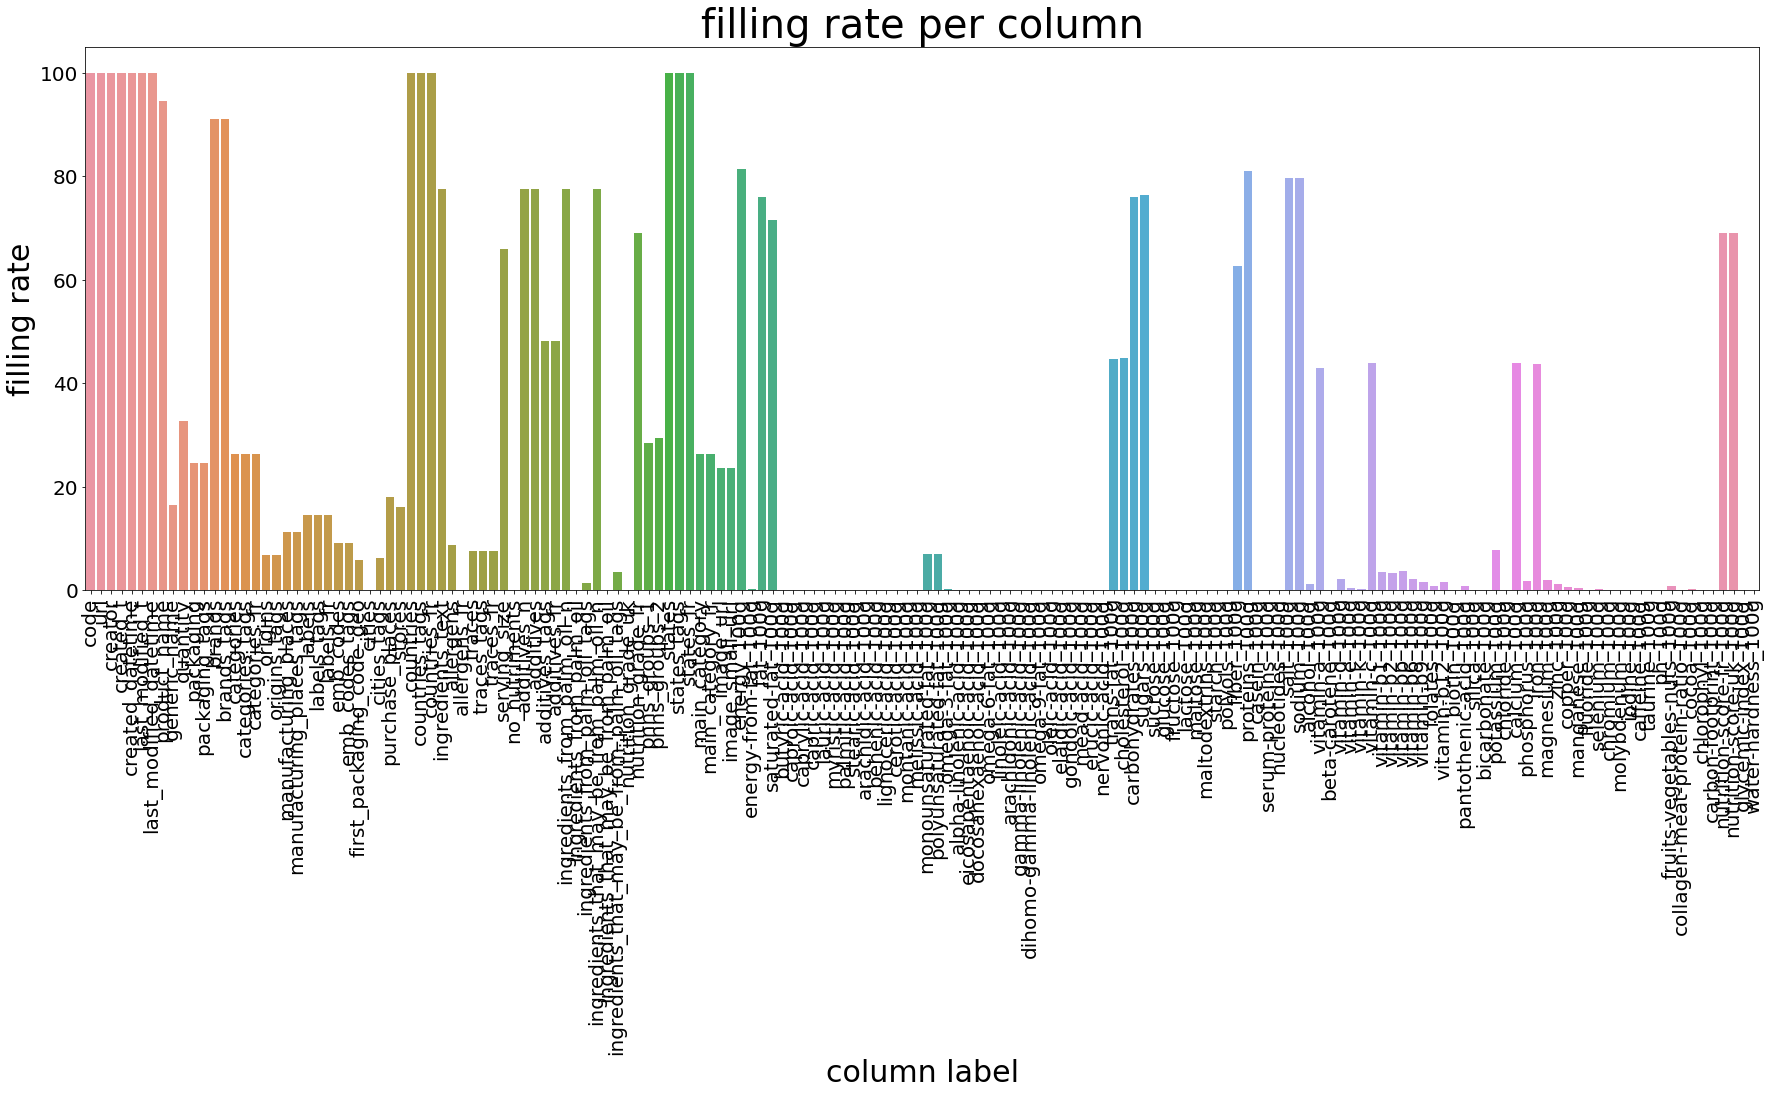

In [12]:
#Graphic for filling rate
plot_filling_rate(df)
plt.savefig ("filling rate all columns P3.png")

In [13]:
# Cut columns with filling rate <50%
df = cut_cols(df,0.5)

In [14]:
df.shape

(320772, 34)

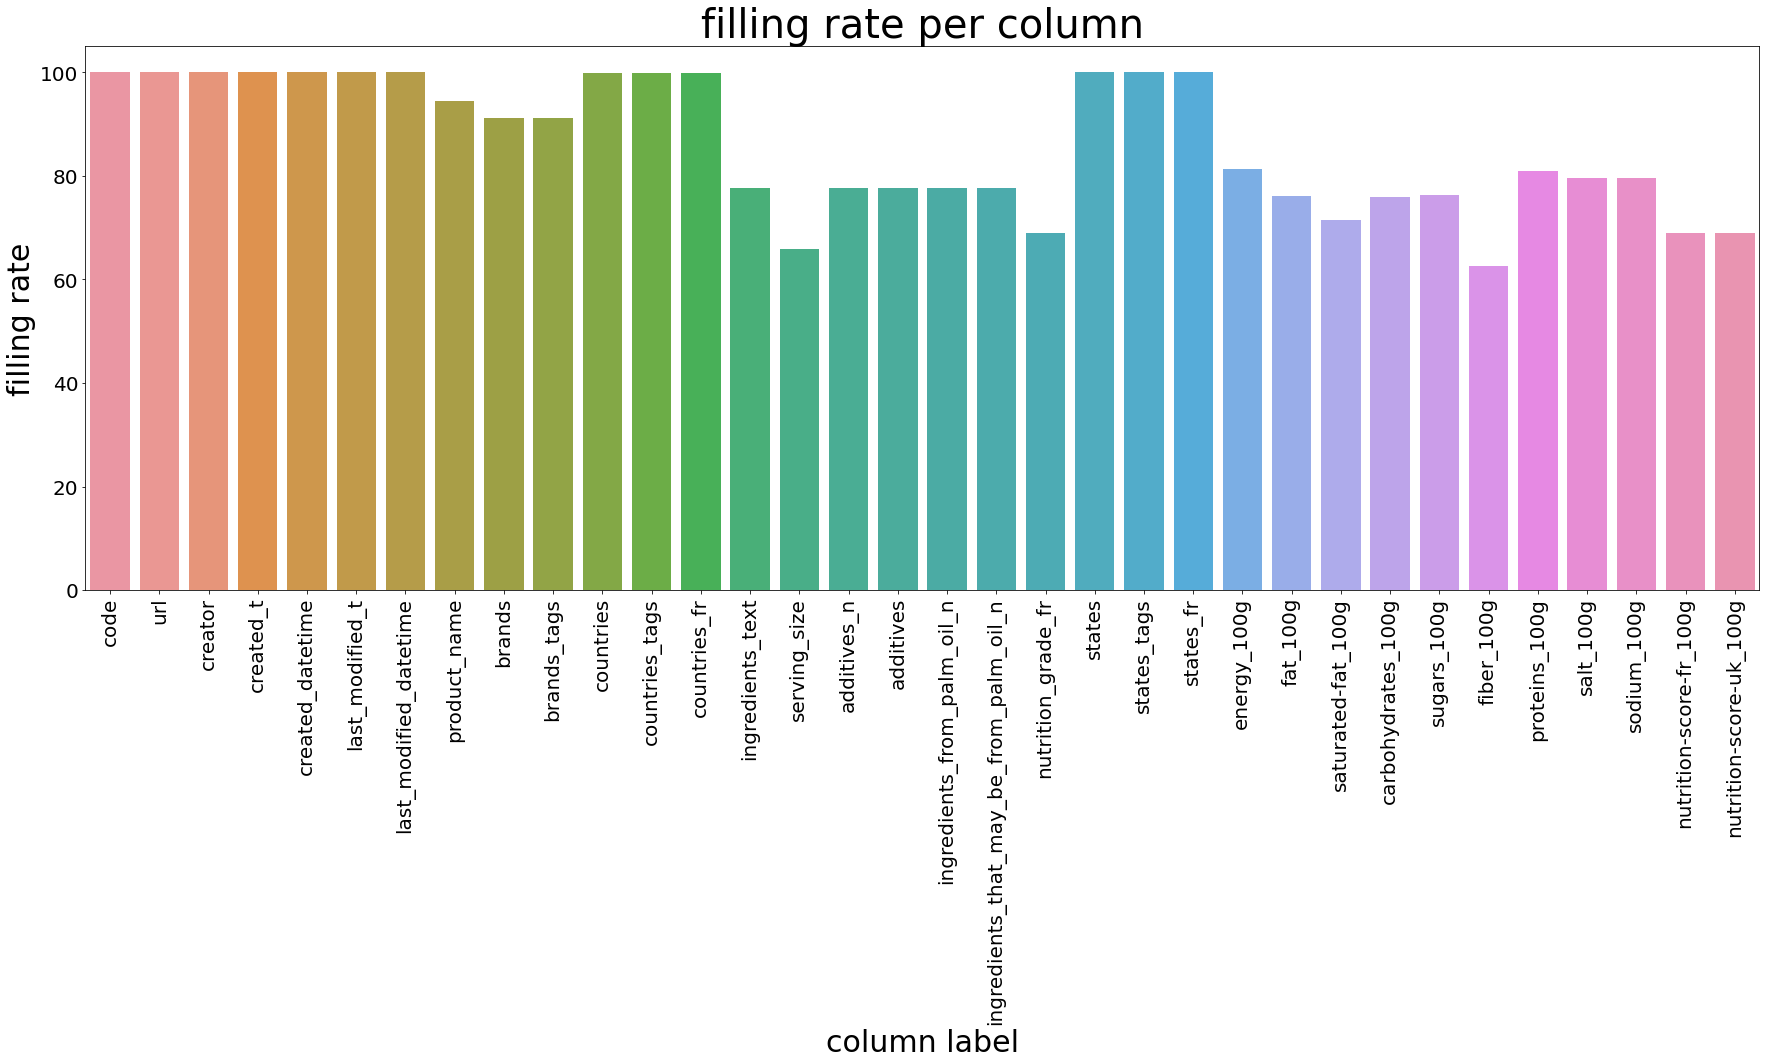

In [15]:
plot_filling_rate(df)
plt.savefig ("filling rate more 50.png")

In [16]:
df.columns

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name', 'brands',
       'brands_tags', 'countries', 'countries_tags', 'countries_fr',
       'ingredients_text', 'serving_size', 'additives_n', 'additives',
       'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutrition_grade_fr',
       'states', 'states_tags', 'states_fr', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g'],
      dtype='object')

In [17]:
df[["additives","additives_n","ingredients_text",
    "countries","countries_tags","countries_fr",
    "states","states_tags","states_fr",
   "ingredients_from_palm_oil_n","ingredients_that_may_be_from_palm_oil_n"]
]

,additives,additives_n,ingredients_text,countries,countries_tags,countries_fr,states,states_tags,states_fr,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n
0,NaN,NaN,NaN,en:FR,en:france,France,"en:to-be-completed, en:nutrition-facts-to-be-completed, en:ingredients-to-be-completed, en:expiration-date-to-be-completed, en:characteristics-to-be-completed, en:categories-to-be-completed, en:brands-completed, en:packaging-to-be-completed, en:quantity-completed, en:product-name-completed, en:photos-to-be-validated, en:photos-uploaded","en:to-be-completed,en:nutrition-facts-to-be-completed,en:ingredients-to-be-completed,en:expiration-date-to-be-completed,en:characteristics-to-be-completed,en:categories-to-be-completed,en:brands-completed,en:packaging-to-be-completed,en:quantity-completed,en:product-name-completed,en:photos-to-be-validated,en:photos-uploaded","A compléter,Informations nutritionnelles à compléter,Ingrédients à compléter,Date limite à compléter,Caractéristiques à compléter,Catégories à compléter,Marques complétées,Emballage à compléter,Quantité complétée,Nom du produit complete,Photos à valider,Photos envoyées",NaN,NaN
1,[ bananas -> en:bananas ] [ vegetable-oil -> en:vegetable-oil ] [ oil -> en:oil ] [ coconut-oil -> en:coconut-oil ] [ oil -> en:oil ] [ corn-oil-and-or-palm-oil-sugar -> en:corn-oil-and-or-palm-oil-sugar ] [ oil-and-or-palm-oil-sugar -> en:oil-and-or-palm-oil-sugar ] [ and-or-palm-oil-sugar -> en:and-or-palm-oil-sugar ] [ or-palm-oil-sugar -> en:or-palm-oil-sugar ] [ palm-oil-sugar -> en:palm-oil-sugar ] [ oil-sugar -> en:oil-sugar ] [ sugar -> en:sugar ] [ natural-banana-flavor -> en:natural-banana-flavor ] [ banana-flavor -> en:banana-flavor ] [ flavor -> en:flavor ],0.0,"Bananas, vegetable oil (coconut oil, corn oil and/or palm oil) sugar, natural banana flavor.",US,en:united-states,États-Unis,"en:to-be-completed, en:nutrition-facts-completed, en:ingredients-completed, en:expiration-date-to-be-completed, en:packaging-code-to-be-completed, en:characteristics-to-be-completed, en:categories-to-be-completed, en:brands-to-be-completed, en:packaging-to-be-completed, en:quantity-to-be-completed, en:product-name-completed, en:photos-to-be-uploaded","en:to-be-completed,en:nutrition-facts-completed,en:ingredients-completed,en:expiration-date-to-be-completed,en:packaging-code-to-be-completed,en:characteristics-to-be-completed,en:categories-to-be-completed,en:brands-to-be-completed,en:packaging-to-be-completed,en:quantity-to-be-completed,en:product-name-completed,en:photos-to-be-uploaded","A compléter,Informations nutritionnelles complétées,Ingrédients complétés,Date limite à compléter,en:Packaging-code-to-be-completed,Caractéristiques à compléter,Catégories à compléter,Marques à compléter,Emballage à compléter,Quantité à compléter,Nom du produit complete,Photos à envoyer",0.0,0.0
2,[ peanuts -> en:peanuts ] [ wheat-flour -> en:wheat-flour ] [ flour -> en:flour ] [ sugar -> en:sugar ] [ rice-flour -> en:rice-flour ] [ flour -> en:flour ] [ tapioca-starch -> en:tapioca-starch ] [ starch -> en:starch ] [ salt -> en:salt ] [ leavening -> en:leavening ] [ ammonium-bicarbonate -> en:ammonium-bicarbonate ] [ bicarbonate -> en:bicarbonate ] [ baking-soda -> en:baking-soda ] [ soda -> en:soda ] [ soy-sauce -> en:soy-sauce ] [ sauce -> en:sauce ] [ water -> en:water ] [ soybeans -> en:soybeans ] [ wheat -> en:wheat ] [ salt -> en:salt ] [ potato-starch -> en:potato-starch ] [ starch -> en:starch ],0.0,"Peanuts, wheat flour, sugar, rice flour, tapioca starch, salt, leavening (ammonium bicarbonate, baking soda), soy sauce (water, soybeans, wheat, salt), potato starch.",US,en:united-states,États-Unis,"en:to-be-completed, en:nutrition-facts-completed, en:ingredients-completed, en:expiration-date-to-be-completed, en:packaging-code-to-be-completed, en:characteristics-to-be-completed, en:categories-to-be-completed, en:brands-completed, en:packaging-to-be-completed, en:quantity-to-be-completed, en:product-name-c

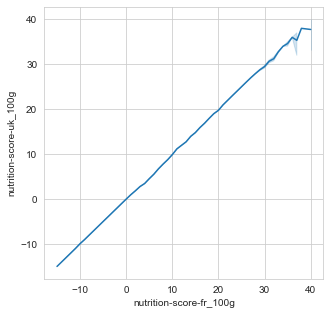

<Figure size 2160x720 with 0 Axes>

In [18]:
#difference and similarity between Fr nutrition score and UK nutrition score
sns.set_style("whitegrid")
plt.figure(figsize=(5,5))
sns.lineplot(data=df,x="nutrition-score-fr_100g",y="nutrition-score-uk_100g")
plt.show()
plt.savefig ("comparaison nutriscore fr et uk.png")

**We have a linear line with slope equal to 1.It means that "nutrition-score-fr_100g"="nutrition-score-uk_100g" so we keep
var with more values**

0.0    237243
1.0    10037 
2.0    1321  
3.0    286   
4.0    45    
5.0    6     
6.0    1     
Name: ingredients_that_may_be_from_palm_oil_n, dtype: int64
0.0    244104
1.0    4776  
2.0    59    
Name: ingredients_from_palm_oil_n, dtype: int64


C:\Users\betas\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\betas\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


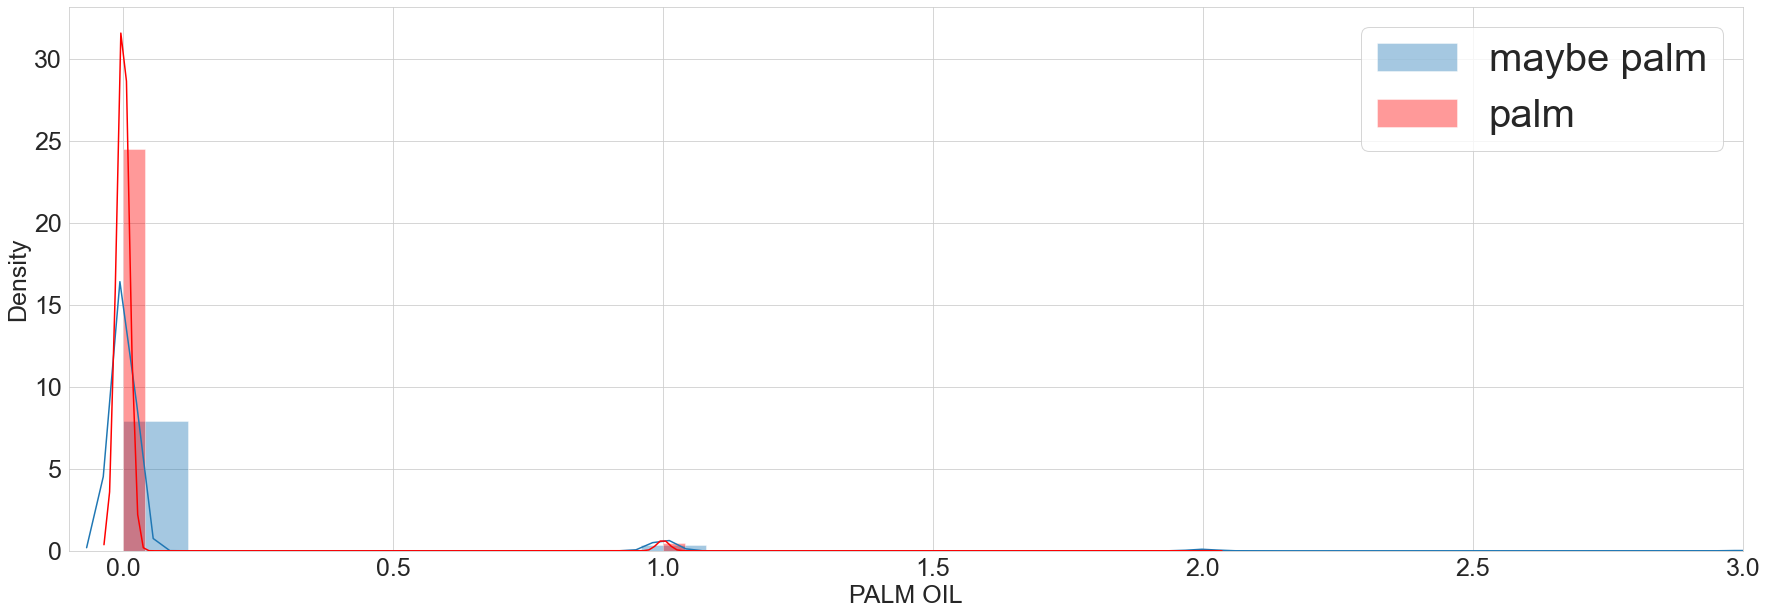

In [19]:
#difference and similarity between ingredients_from_palm_oil_n and ingredients_that_may_be_from_palm_oil_n
print(df["ingredients_that_may_be_from_palm_oil_n"].value_counts())
print(df["ingredients_from_palm_oil_n"].value_counts())

#Distplot for ingredients_from_palm_oil_n and ingredients_that_may_be_from_palm_oil_n
plt.figure()
plt.rc('legend', fontsize=40)

sns.distplot(df["ingredients_that_may_be_from_palm_oil_n"],label="maybe palm")
sns.distplot(df["ingredients_from_palm_oil_n"], label="palm",color='red')
plt.xlim([-0.1,3])
plt.xticks(size=25)
plt.xlabel("PALM OIL",size=25)
plt.yticks(size=25)
plt.ylabel("Density",size=25)
plt.legend()


In [20]:
#Cut repetitif and useless columns
deleted_columns=["code","countries","countries_tags","brands_tags","brands","states_tags","states_fr","url",
              "additives","nutrition-score-uk_100g","serving_size" , "creator" , "created_t" , "last_modified_t",
             "ingredients_from_palm_oil_n","states","states_tags","states_fr","nutrition-score-uk_100g",
            ]
df = df.drop(deleted_columns, axis=1)
df


,created_datetime,last_modified_datetime,product_name,countries_fr,ingredients_text,additives_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g
0,2016-09-17T09:17:46Z,2016-09-17T09:18:13Z,Farine de blé noir,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-03-09T14:32:37Z,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),États-Unis,"Bananas, vegetable oil (coconut oil, corn oil and/or palm oil) sugar, natural banana flavor.",0.0,0.0,d,2243.0,28.57,28.57,64.29,14.29,3.6,3.57,0.00000,0.000,14.0
2,2017-03-09T14:32:37Z,2017-03-09T14:32:37Z,Peanuts,États-Unis,"Peanuts, wheat flour, sugar, rice flour, tapioca starch, salt, leavening (ammonium bicarbonate, baking soda), soy sauce (water, soybeans, wheat, salt), potato starch.",0.0,0.0,b,1941.0,17.86,0.00,60.71,17.86,7.1,17.86,0.63500,0.250,0.0
3,2017-03-09T10:35:31Z,2017-03-09T10:35:31Z,Organic Salted Nut Mix,États-Unis,"Organic hazelnuts, organic cashews, organic walnuts almonds, organic sunflower oil, sea salt.",0.0,0.0,d,2540.0,57.14,5.36,17.86,3.57,7.1,17.86,1.22428,0.482,12.0
4,2017-03-09T10:34:13Z,2017-03-09T10:34:13Z,Organic Polenta,États-Unis,Organic polenta,0.0,0.0,NaN,1552.0,1.43,NaN,77.14,NaN,5.7,8.57,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320767,2017-03-27T16:14:59Z,2017-04-03T18:34:58Z,Tomato & ricotta,Roumanie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320768,2017-03-09T11:31:16Z,2017-04-03T18:34:59Z,"Mint Melange Tea A Blend Of Peppermint, Lemon Grass And Spearmint",États-Unis,"Organic peppermint, organic lemon grass, organic spearmint.",0.0,0.0,b,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00000,0.000,0.0
320769,2015-01-24T11:36:17Z,2017-04-03T18:34:59Z,乐吧泡菜味薯片,Chine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320770,2017-04-16T10:54:49Z,2017-04-16T10:54:49Z,Tomates aux Vermicelles,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
#convert to datetime  
df["created_datetime"]=pd.to_datetime(df["created_datetime"], errors='coerce')
df["last_modified_datetime"]=pd.to_datetime(df["last_modified_datetime"],errors='coerce')
df.dtypes

created_datetime                           datetime64[ns, UTC]
last_modified_datetime                     datetime64[ns, UTC]
product_name                               object             
countries_fr                               object             
ingredients_text                           object             
additives_n                                float64            
ingredients_that_may_be_from_palm_oil_n    float64            
nutrition_grade_fr                         object             
energy_100g                                float64            
fat_100g                                   float64            
saturated-fat_100g                         float64            
carbohydrates_100g                         float64            
sugars_100g                                float64            
fiber_100g                                 float64            
proteins_100g                              float64            
salt_100g                                  float64     

In [22]:
df.dtypes.value_counts()

float64                12
object                 4 
datetime64[ns, UTC]    2 
dtype: int64

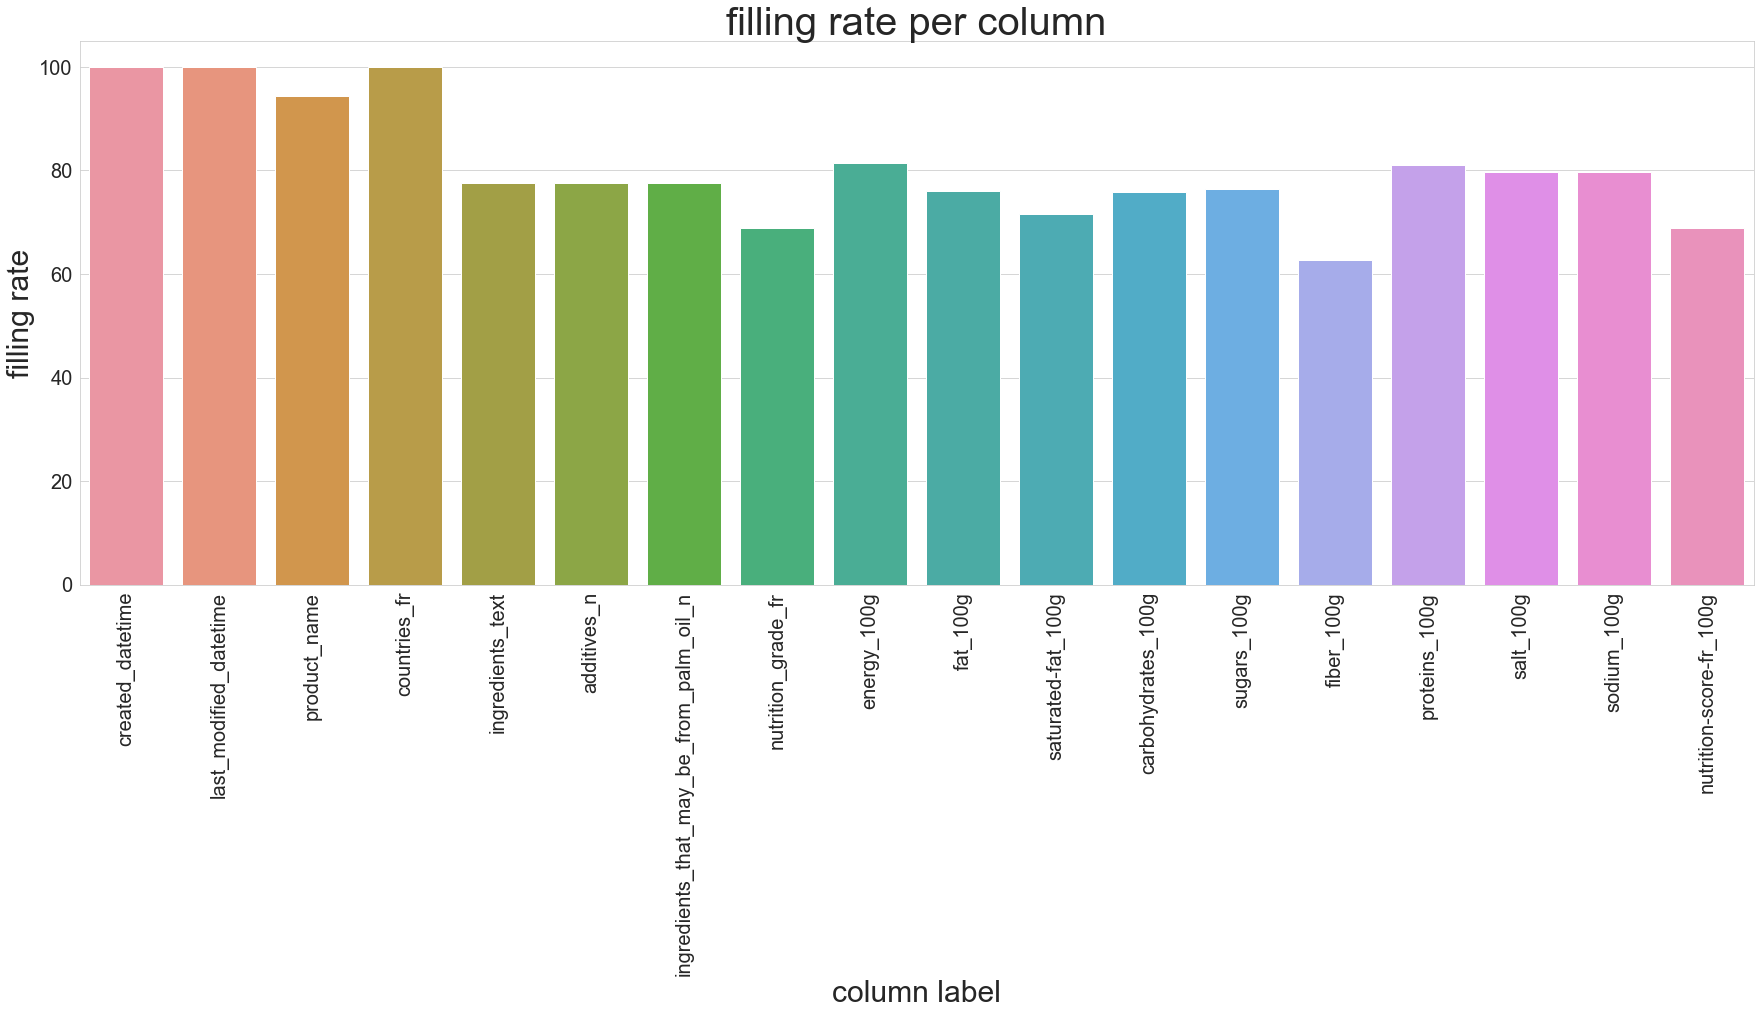

In [23]:
plot_filling_rate (df)

### Outliers management

In [24]:
# Change "nutrition-score-fr_100g " column name to "nutri_score"
df.rename({'nutrition-score-fr_100g' : 'nutri_score', "ingredients_that_may_be_from_palm_oil_n" : "palm_oil_n"} ,
          axis=1 , inplace=True)

In [25]:
def select_100g_cols (data) :
    """
    To create a DataFrame with float columns containing only 100g ingredient except the energy
    args: pandas dataframe
        data:
    return:
        dataframe
    """
    cols_100g = data.filter(regex="_100g")
    cols_100g = cols_100g.drop(labels="energy_100g",axis=1)
   
    return cols_100g

#########################

def normalize_100g_Vars (data) :
    
    """ 
    Check if 100g ingredient values are between 0 and 100g
    args : 
        data :Pandas dataframe , cols_100g
    return :
        data : normalized dataframe
    """
    data.mask ( (data>100)|(data<0) , inplace = True )
    data["saturated-fat_100g"].mask ( (data["saturated-fat_100g"] > data["fat_100g"]) , inplace=True )
    data["sugars_100g"].mask ( (data["sugars_100g"] > data["carbohydrates_100g"]) , inplace=True)
    data["sodium_100g"].mask ( (data["sodium_100g"] > data["salt_100g"]) , inplace=True)

    data["sum_100g"] = data.sum(axis=1)-(data["saturated-fat_100g"] + data["sugars_100g"] + data["sodium_100g"])
    data["sum_100g"].mask ( data["sum_100g"]>100 , inplace = True)
    
    return data
    
    
    
    
##########################

def normalize_energy (data) :
    """
    
    Replace energy values that exceed 3800kJ and negative with NaN  
    args : 
        data : Pandas dataframe
    return :
        Descriptive statistics (max, min , quantile) dataframe 


    
    """
    
    data.mask ((data[['energy_100g']]>3800) | (data[['energy_100g']]<0) , inplace=True ) 
    
    return data['energy_100g'].describe () 

#########################

def normalize_df (data1 , data2) :
    """
    concatenate dataframes with normalized float (energy and 100g ingredients) and object Vars
        args : 
            data : Pandas Dataframe
        return
            data : 
            
    """
    
    list_100g = normalize_100g_Vars(select_100g_cols(df)).columns.to_list() 
    list_100g.remove('sum_100g')
    data1.drop (labels=list_100g , axis=1 , inplace=True)
    norm_df = pd.concat ( [data1, data2] , axis=1 )
    norm_df = norm_df [~ norm_df["sum_100g"].isnull()].reset_index (drop=True)
    norm_df.drop(labels="sum_100g" , axis=1 , inplace= True)
    
    return norm_df

In [26]:
describe_df = df.describe()
describe_df.to_csv("describe.csv" , sep=",")
describe_df

,additives_n,palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutri_score
count,248939.00000000,248939.00000000,2.61113000e+05,243891.00000000,229554.00000000,243588.00000000,244971.00000000,200886.00000000,259922.00000000,255510.00000000,255463.00000000,221210.00000000
mean,1.93602449,0.05524647,1.14191460e+03,12.73037857,5.12993230,32.07398108,16.00348355,2.86211095,7.07593966,2.02862395,0.79881546,9.16553501
std,2.50201947,0.26920744,6.44715409e+03,17.57874669,8.01423814,29.73171946,22.32728440,12.86757803,8.40905424,128.26945442,50.50442790,9.05590292
min,0.00000000,0.00000000,0.00000000e+00,0.00000000,0.00000000,0.00000000,-17.86000000,-6.70000000,-800.00000000,0.00000000,0.00000000,-15.00000000
25%,0.00000000,0.00000000,3.77000000e+02,0.00000000,0.00000000,6.00000000,1.30000000,0.00000000,0.70000000,0.06350000,0.02500000,1.00000000
50%,1.00000000,0.00000000,1.10000000e+03,5.00000000,1.79000000,20.60000000,5.71000000,1.50000000,4.76000000,0.58166000,0.22900000,10.00000000
75%,3.00000000,0.00000000,1.67400000e+03,20.00000000,7.14000000,58.33000000,24.00000000,3.60000000,10.00000000,1.37414000,0.54100000,16.00000000
max,31.00000000,6.00000000,3.25137300e+06,714.29000000,550.00000000,2916.67000000,3520.00000000,5380.00000000,430.00000000,64312.80000000,25320.00000000,40.00000000


**- cols_100g values must be between 0 and 100g**  

**- cols_100g sum except energy must be positive and do not exceed 100g**  

**- energy_100g can't be over 3800 kJ**

**- fat_100g and carbohydrates_100g must be upper to saturated-fat_100g and sugars_100g respectively**

C:\Users\betas\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\betas\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


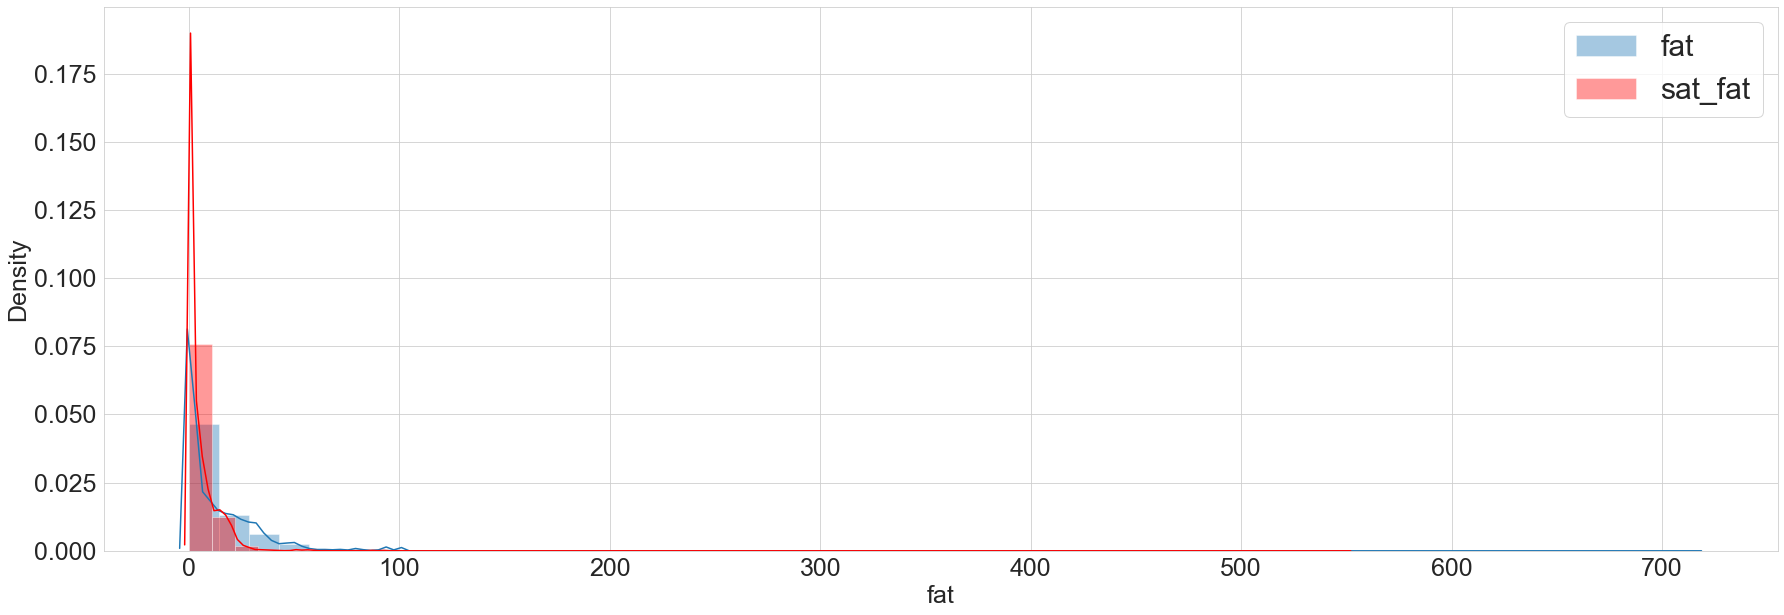

In [27]:
#Distplot for ingredients_from_palm_oil_n and ingredients_that_may_be_from_palm_oil_n
plt.figure()
plt.rc('legend', fontsize=30)

sns.distplot(df["fat_100g"],label="fat")
sns.distplot(df["saturated-fat_100g"], label="sat_fat",color='red')
plt.xticks(size=25)
plt.xlabel("fat",size=25)
plt.yticks(size=25)
plt.ylabel("Density",size=25)
plt.legend()


In [28]:
#Create a Dataframe containing nutritinal information per 100g
select_100g_cols(df)

,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,28.57,28.57,64.29,14.29,3.6,3.57,0.00000,0.000
2,17.86,0.00,60.71,17.86,7.1,17.86,0.63500,0.250
3,57.14,5.36,17.86,3.57,7.1,17.86,1.22428,0.482
4,1.43,NaN,77.14,NaN,5.7,8.57,NaN,NaN
...,...,...,...,...,...,...,...,...
320767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320768,0.00,0.00,0.00,0.00,0.0,0.00,0.00000,0.000
320769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
normalize_100g_Vars(select_100g_cols(df))

,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,sum_100g
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,28.57,28.57,64.29,14.29,3.6,3.57,0.00000,0.000,NaN
2,17.86,0.00,60.71,17.86,7.1,17.86,0.63500,0.250,NaN
3,57.14,5.36,17.86,3.57,7.1,17.86,1.22428,0.482,NaN
4,1.43,NaN,77.14,NaN,5.7,8.57,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
320767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320768,0.00,0.00,0.00,0.00,0.0,0.00,0.00000,0.000,0.0
320769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
normalize_energy(df)

count    260756.00000000
mean     1121.54392687  
std      792.52097970   
min      0.00000000     
25%      375.00000000   
50%      1100.00000000  
75%      1674.00000000  
max      3776.00000000  
Name: energy_100g, dtype: float64

In [31]:
norm_df = normalize_df (df , normalize_100g_Vars(select_100g_cols(df)))

In [32]:
norm_df = cut_rows (norm_df , 0.5)
norm_df

,created_datetime,last_modified_datetime,product_name,countries_fr,ingredients_text,additives_n,palm_oil_n,nutrition_grade_fr,energy_100g,nutri_score,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g
0,2017-03-09 10:34:10+00:00,2017-03-09 10:34:11+00:00,Zen Party Mix,États-Unis,"Roasted peanuts (peanuts, peanut or canola oil, salt), sesame sticks (unbleached wheat flour, sesame seeds, sunflower oil, sa;t, beet powder, turmeric), chili crackers (rice, corn starch, soy sauce[water, soybeans, wheat, salt], brown rice syrup, paprika, onion powder, garlic powder), tamari roasted almonds (almonds, tamari shoyu [water, wheat, soybeans, salt]), salt",1.0,0.0,d,2230.0,12.0,36.67,5.00,36.67,3.33,6.7,16.67,1.60782,0.63300000
1,2017-03-09 10:34:42+00:00,2017-03-09 10:34:42+00:00,Organic Oat Groats,États-Unis,Organic oat groats,0.0,0.0,a,1096.0,-6.0,5.95,1.19,66.67,2.38,9.5,16.67,0.02540,0.01000000
2,2017-03-09 10:35:06+00:00,2017-03-09 10:35:06+00:00,Energy Power Mix,États-Unis,"Yogurt raisins, tamari roasted almonds, organic tamari roasted soy nuts, dark chocolate stars, cranberries, dark chocolate chips, peanut butter chips, milk chocolate raisins, pineapple, papaya, peanut butter peanuts & raisins, roasted peanuts.",0.0,0.0,d,1464.0,14.0,17.50,7.50,42.50,32.50,5.0,7.50,0.28448,0.11200000
3,2017-03-09 10:35:21+00:00,2017-03-09 10:35:21+00:00,Fire Roasted Hatch Green Chile Almonds,États-Unis,"Dry roasted almonds, hatch green chile seasoning (organic cheddar cheese powder [organic cheddar cheese {cultured pasteurized milk, salt, enzymes}, organic nonfat milk,organic whey, salt, sodium phosphate], salt, hatch green chile pepper, evaporated cane juice, onion, parsely, natural flavors,garlic, maltodextrin, spices, spices extractives, citric acid), expeller pressed canola oil.",2.0,0.0,d,2372.0,11.0,50.00,3.33,23.33,6.67,10.0,6.67,1.27000,0.50000000
4,2017-03-10 09:34:46+00:00,2017-03-10 09:34:46+00:00,Peanut Butter Power Chews,États-Unis,"Peanut butter (dry roasted peanuts, palm oil, salt), honey, crispy brown rice (brown rice flour [rice flour, rice bran], honey, calcium carbonate), barley malt, soy lecithin (an emulsifier), sea salt, locust bean gum, carrageenan gum.",3.0,0.0,c,1954.0,9.0,20.00,2.22,60.00,33.33,4.4,8.89,0.19812,0.07800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200457,2017-03-09 20:45:00+00:00,2017-03-09 20:45:00+00:00,Natural Cassava,États-Unis,Cassava.,0.0,0.0,a,1477.0,-1.0,0.00,0.00,87.06,2.35,4.7,1.18,0.03048,0.01200000
200458,2015-07-25 09:47:06+00:00,2015-09-14 13:37:28+00:00,Tartines craquantes bio au sarrasin,France,NaN,NaN,NaN,a,1643.0,-4.0,2.80,0.60,74.80,2.60,5.9,13.00,0.68000,0.26771654
200459,2017-04-01 20:52:18+00:00,2017-04-01 20:52:19+00:00,Amandes,France,NaN,NaN,NaN,b,2406.0,0.0,NaN,3.73,NaN,3.89,12.2,21.22,0.10000,0.03937008
200460,2013-04-28 15:30:39+00:00,2013-06-20 01:09:16+00:00,Thé vert Earl grey,France,"thé vert, arôme naturel bergamote avec autres arômes naturels, écorces d'orange douce 3%",0.0,0.0,c,21.0,2.0,0.20,0.20,0.50,0.50,0.2,0.50,0.02540,0.01000000


In [33]:
norm_df.shape

(200458, 18)

In [34]:
norm_df.isnull().mean (axis=1).max()

0.4444444444444444

In [35]:
norm_df.dtypes.value_counts()

float64                12
object                 4 
datetime64[ns, UTC]    2 
dtype: int64

In [36]:
norm_df.describe()

,additives_n,palm_oil_n,energy_100g,nutri_score,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g
count,175591.00000000,175591.00000000,200144.00000000,199427.00000000,183178.00000000,200458.00000000,183065.00000000,200458.00000000,173207.00000000,199953.00000000,200430.00000000,200458.00000000
mean,2.07609160,0.06353970,1082.96632469,8.79851775,11.69501684,4.62715904,30.80478304,14.37620201,2.11577750,7.31287793,1.24281357,0.49636677
std,2.58502033,0.28947881,724.20619926,9.06384002,14.97482767,7.27447468,27.91254345,19.48462583,3.28911627,7.82794240,4.00066897,1.69275835
min,0.00000000,0.00000000,0.00000000,-15.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
25%,0.00000000,0.00000000,410.00000000,1.00000000,0.50000000,0.00000000,6.25000000,1.18000000,0.00000000,1.56000000,0.10000000,0.03937008
50%,1.00000000,0.00000000,1050.00000000,9.00000000,5.70000000,1.50000000,19.80000000,4.80000000,1.20000000,5.00000000,0.63500000,0.25000000
75%,3.00000000,0.00000000,1615.00000000,16.00000000,18.70000000,6.67000000,55.80000000,21.43000000,3.10000000,10.13000000,1.37000000,0.53937008
max,31.00000000,6.00000000,3776.00000000,40.00000000,100.00000000,100.00000000,100.00000000,100.00000000,100.00000000,94.70000000,100.00000000,92.50000000


In [37]:
 # To split normalized dataframe to multi^ple dataframes according to column variable types 
string_data= norm_df.select_dtypes (include = "object")
numeric_data=norm_df.select_dtypes (include = "float64")


In [38]:
for col in numeric_data.columns : 
    maximum = norm_df[col].max()
    print ("les produits ayant un maximum de ", col, "sont : " , norm_df[norm_df[col] == maximum]["product_name"].unique())

les produits ayant un maximum de  additives_n sont :  ['Italian Style Pinwheels' 'Confiserie']
les produits ayant un maximum de  palm_oil_n sont :  ['Tarta de Chocolate con Milka']
les produits ayant un maximum de  energy_100g sont :  ['Huile de coco']
les produits ayant un maximum de  nutri_score sont :  ['Cappuccino allégé en sucre*']
les produits ayant un maximum de  fat_100g sont :  ['Ventura, Soybean - Peanut Frying Oil Blend' 'Corn Oil' 'Canola Oil'
 'Vegetable Oil' 'Vegetable Shortening' 'Premium Sesame Oil (100% Pure)'
 'Sesame Oil' 'Premium Sesame Oil, Hot' 'Refined Coconut Oil'
 'Virgin Coconut Oil' '100% Pure Canola Oil' 'Pure Cow Ghee'
 'Purity Farms Ghee Clarified Butter' 'Farms Ghee'
 'Real Theater Popcorn Popping Oil' 'Virgin coconut oil'
 'Aceite de Coco Orgánico' 'Hot Pepper Sesame Oil' 'Suncokretovo ulje'
 '100% Virgin Pecan Oil' 'X Virgin Olive Oil' 'Extra Virgin Olive Oil'
 'Pure Olive Oil' 'Pre-Creamed Shortening'
 'Cm Colorado Mills, Sunflower Oil' 'Extra Virgin C

In [40]:
norm_df[norm_df["fiber_100g"] > 80]["product_name"].unique()

array(["Mix'Gom", 'Isotonic Sport Drink', 'Noix sèches', 'Agar-agar',
       'Konjac Cuisine', 'Psyllium Blond',
       'Psyllium Blond En Poudre Bio - 600 G - Ethnoscience', 'Agar-Agar',
       'Sour Gums Mixed 400g'], dtype=object)

In [41]:
norm_df[norm_df["sodium_100g"] > 60]["product_name"].unique()

array(['Fratelli Comino, Tochetti With Sea Salt',
       "Light & Fit Greek Crunch - S'mores", 'Garlic Salt',
       'Pure Carrot With Organic Lemon Juice', 'Piri-Piri Hot Sauce',
       'Keeny Bio'], dtype=object)

In [42]:
norm_df[norm_df["salt_100g"] > 90]["product_name"].unique()

array(['Sea Salt', 'Real Salt, Fine Salt', 'Kosher Salt',
       'Morton Iodized Salt', 'Premium Quality Sea Salt',
       'Natural Fine Mediterranean Sea Salt', 'Coarse Sea Salt',
       'Garlic Salt', 'Sweet Pickle Mix',
       'Hawaiian seasonning salt original', 'Seasoning Salt',
       'Adobo All-Purpose Seasoning', 'Adobo All Purpose Seasoning',
       'Italia Classics Truffle Salt', 'Iodized Salt & Black Pepper',
       'Salt', 'Iodized Salt', 'Fine Crystals Sea Salt',
       'Himalayan Pink Salt', 'Spice It!, Seasoned Salt', 'Lemon Pepper',
       'Onion Salt', 'Popcorn Salt', 'Pink Salt', 'Pink Curing Salt',
       'Himalania, Coarse Pink Salt Grinder',
       'Natierra, Himalania, Fine Ice Salt',
       'Natierra, Inkasalt Fine Pink Salt',
       'Natierra, Desert Pearl Salt Grinder', 'Himalayan Pink Rock Salt',
       'Original Tenderizer, Seasoned',
       'Tenderizier, Unseasoned, Original',
       'Fine Atlantic Ocean Sea Salt', 'Kosher Flake Salt',
       'Jodsalz fein',

In [43]:
norm_df["product_name"] = norm_df["product_name"].str.lower()
norm_df["ingredients_text"] = norm_df["ingredients_text"].str.lower()

In [44]:
duplicate_cols = ['additives_n', 'palm_oil_n', 'energy_100g', 'nutri_score', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g','ingredients_text','product_name']
norm_df = norm_df.drop_duplicates (subset= duplicate_cols , keep='first')

In [45]:
norm_df.shape

(195361, 18)

## Missing value imputation


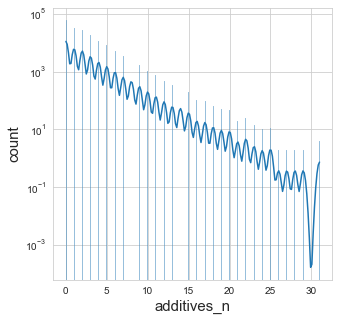

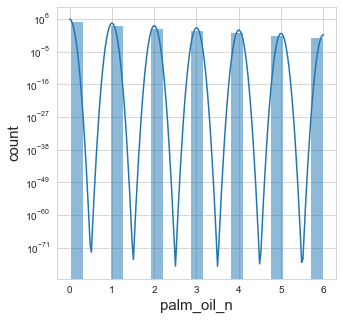

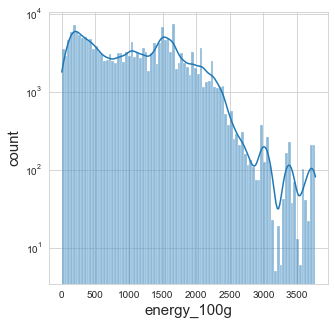

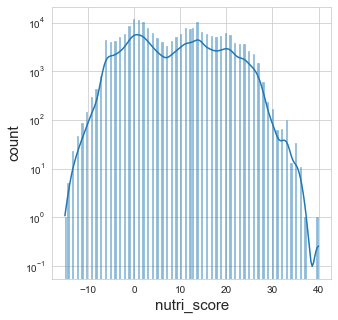

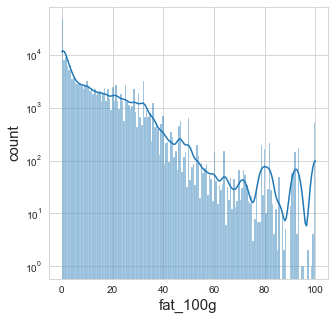

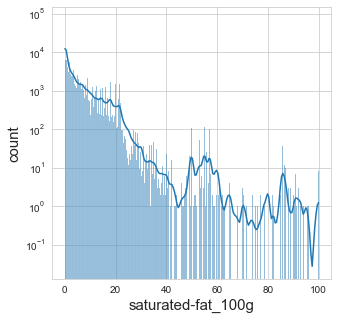

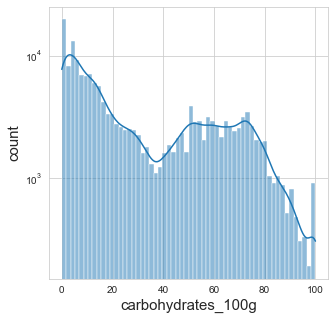

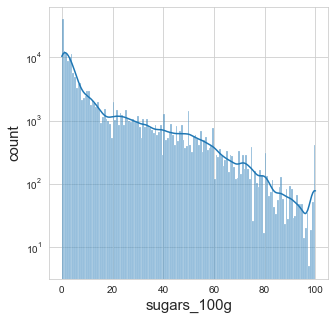

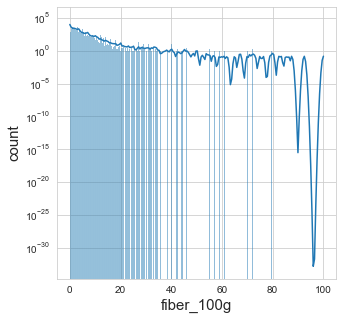

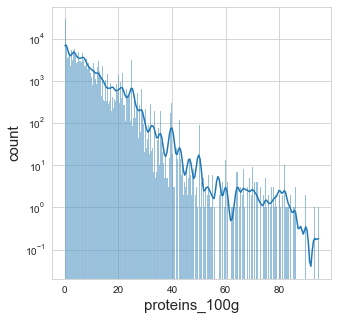

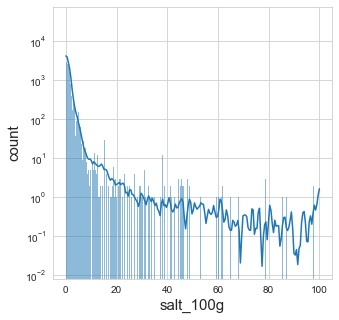

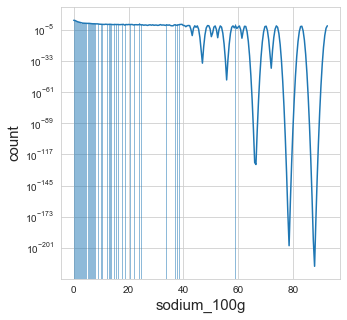

In [39]:
for col in numeric_data.columns :
    plt.figure(figsize=(5,5))
    sns.histplot(norm_df[col] , kde=True )
    plt.yscale ("log")
    plt.xlabel(col, size=15)   
    plt.ylabel("count", size=15)  


In [113]:
for col in numeric_data.columns :
    print (col , stats.kstest (norm_df[col].dropna() , "norm"))

additives_n KstestResult(statistic=0.5455897079596062, pvalue=0.0)
palm_oil_n KstestResult(statistic=0.5, pvalue=0.0)
energy_100g KstestResult(statistic=0.9894646970200001, pvalue=0.0)
nutri_score KstestResult(statistic=0.6977570317129405, pvalue=0.0)
fat_100g KstestResult(statistic=0.6655217932746444, pvalue=0.0)
saturated-fat_100g KstestResult(statistic=0.5, pvalue=0.0)
carbohydrates_100g KstestResult(statistic=0.879222944048664, pvalue=0.0)
sugars_100g KstestResult(statistic=0.6703948232038525, pvalue=0.0)
fiber_100g KstestResult(statistic=0.5, pvalue=0.0)
proteins_100g KstestResult(statistic=0.7077590280172181, pvalue=0.0)
salt_100g KstestResult(statistic=0.5, pvalue=0.0)
sodium_100g KstestResult(statistic=0.5, pvalue=0.0)


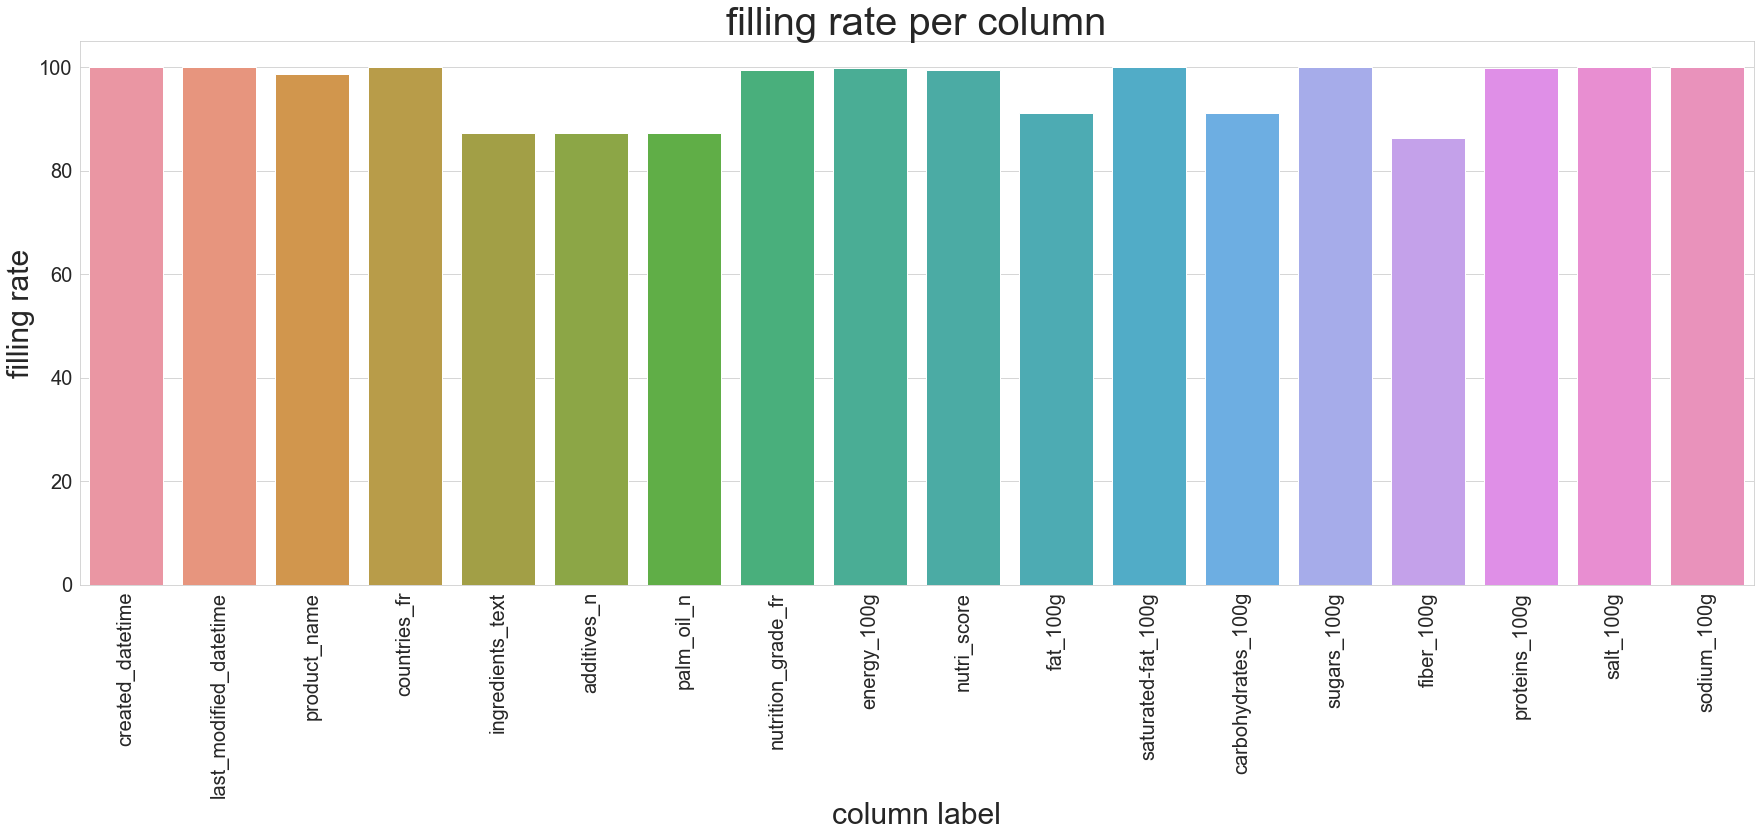

In [53]:
plot_filling_rate(norm_df)

(array([-40., -20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

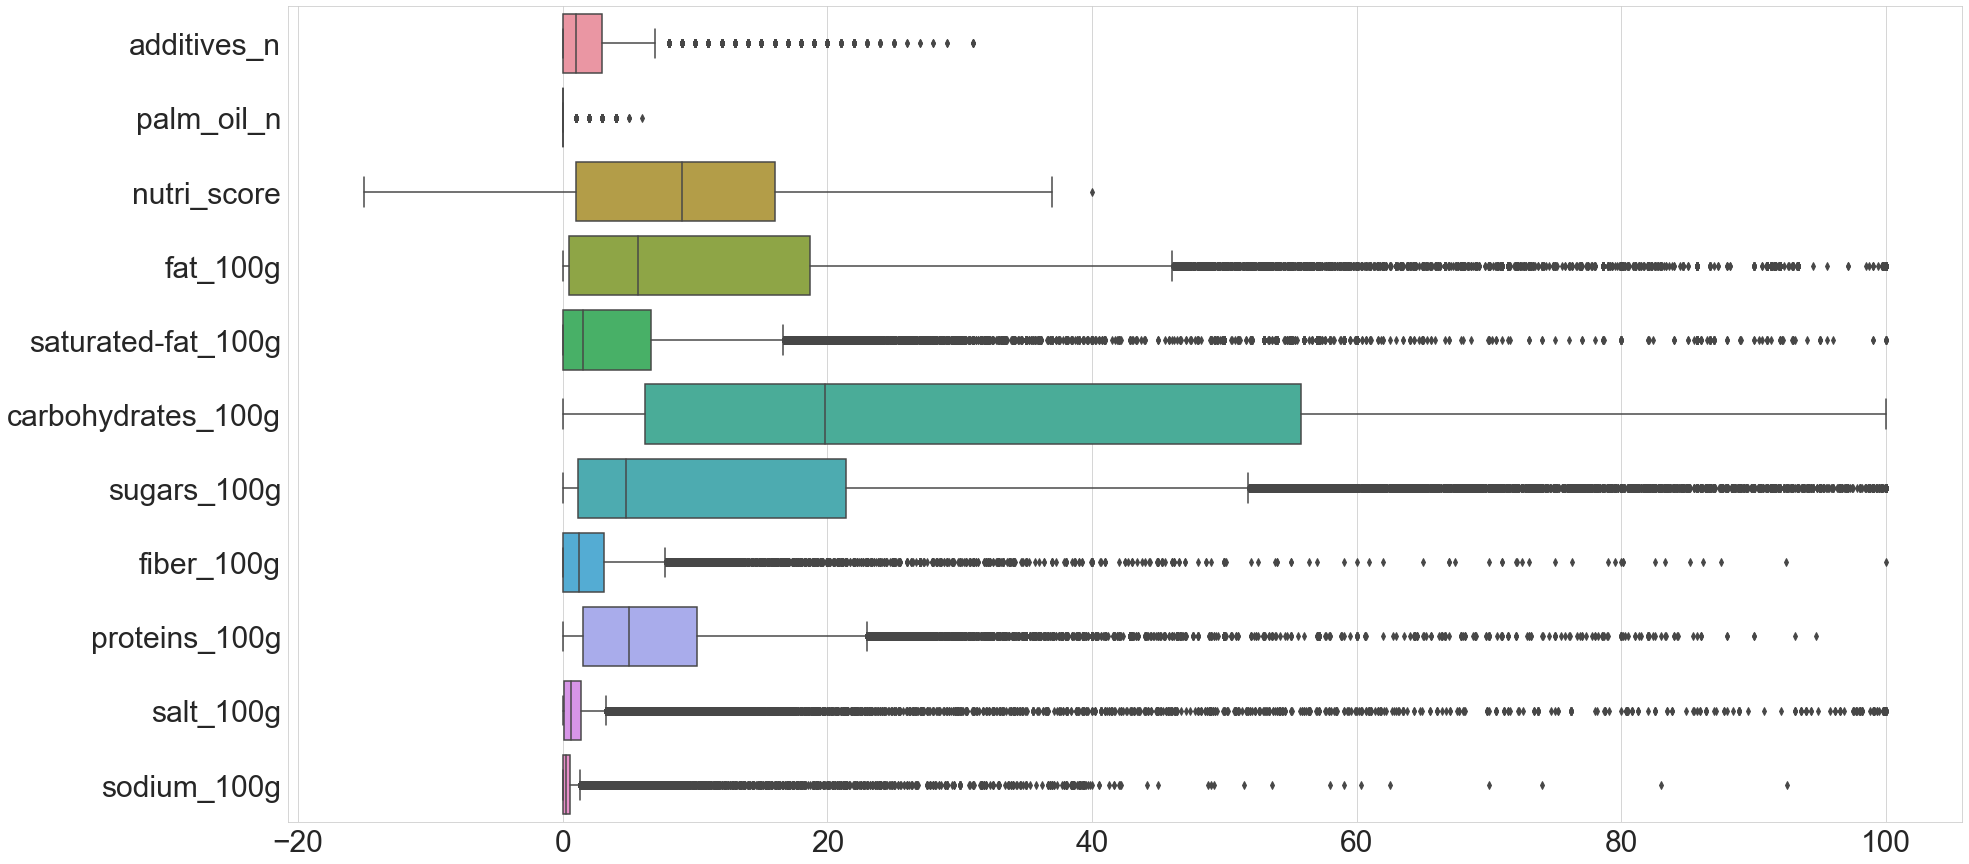

In [54]:
#Boxplot for corr_column
num_data_without_energy = numeric_data.drop (labels="energy_100g", axis=1)
plt.figure(figsize=(30,15))
sns.boxplot(data=num_data_without_energy, orient="h")
plt.yticks(size=30)
plt.xticks(size=30)


Text(0.5, 0, 'energy_100g')

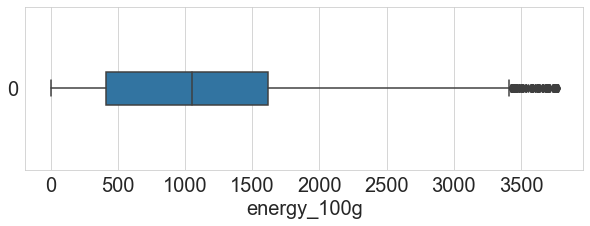

In [55]:
plt.figure(figsize=(10,3))
sns.boxplot(data = numeric_data["energy_100g"], orient="h", width = 0.2)
plt.yticks(size=20)
plt.xticks(size=20)
plt.xlabel("energy_100g" , size=20)

In [56]:
for col in numeric_data.columns :
    print (col , stats.kstest (numeric_data[col].dropna() , "norm"))

additives_n KstestResult(statistic=0.5, pvalue=0.0)
palm_oil_n KstestResult(statistic=0.5, pvalue=0.0)
energy_100g KstestResult(statistic=0.9893409804489495, pvalue=0.0)
nutri_score KstestResult(statistic=0.6928099476799554, pvalue=0.0)
fat_100g KstestResult(statistic=0.6320084495081271, pvalue=0.0)
saturated-fat_100g KstestResult(statistic=0.5, pvalue=0.0)
carbohydrates_100g KstestResult(statistic=0.8678579969161289, pvalue=0.0)
sugars_100g KstestResult(statistic=0.6694610418810572, pvalue=0.0)
fiber_100g KstestResult(statistic=0.5, pvalue=0.0)
proteins_100g KstestResult(statistic=0.7040656697652234, pvalue=0.0)
salt_100g KstestResult(statistic=0.5, pvalue=0.0)
sodium_100g KstestResult(statistic=0.5, pvalue=0.0)


###### Numeric variables distribution is not gaussian

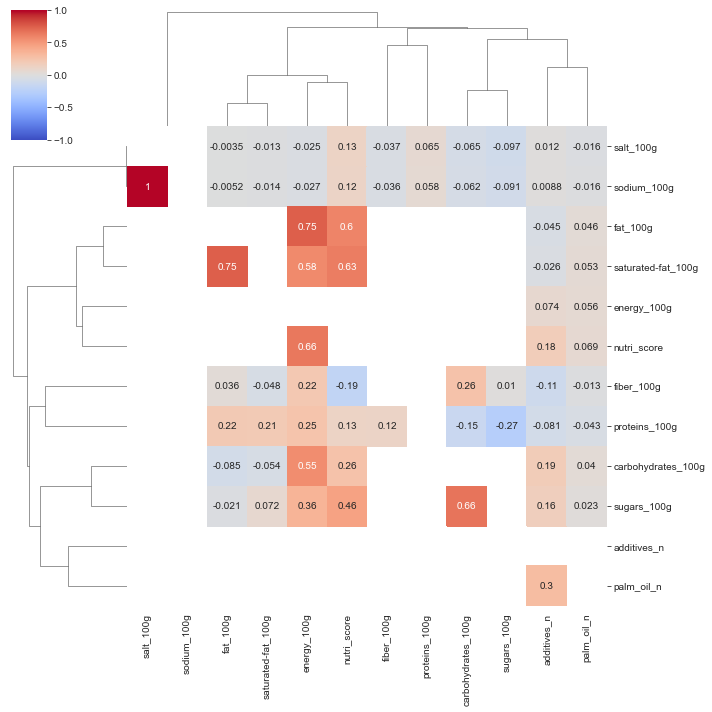

In [57]:
#Correlation between float columns                    
mask = np.triu( numeric_data.corr())
sns.clustermap(numeric_data.corr(), vmin=-1, vmax=+1, annot=True, cmap='coolwarm', mask=mask )
plt.savefig ("corr_map.png")

C:\Users\betas\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


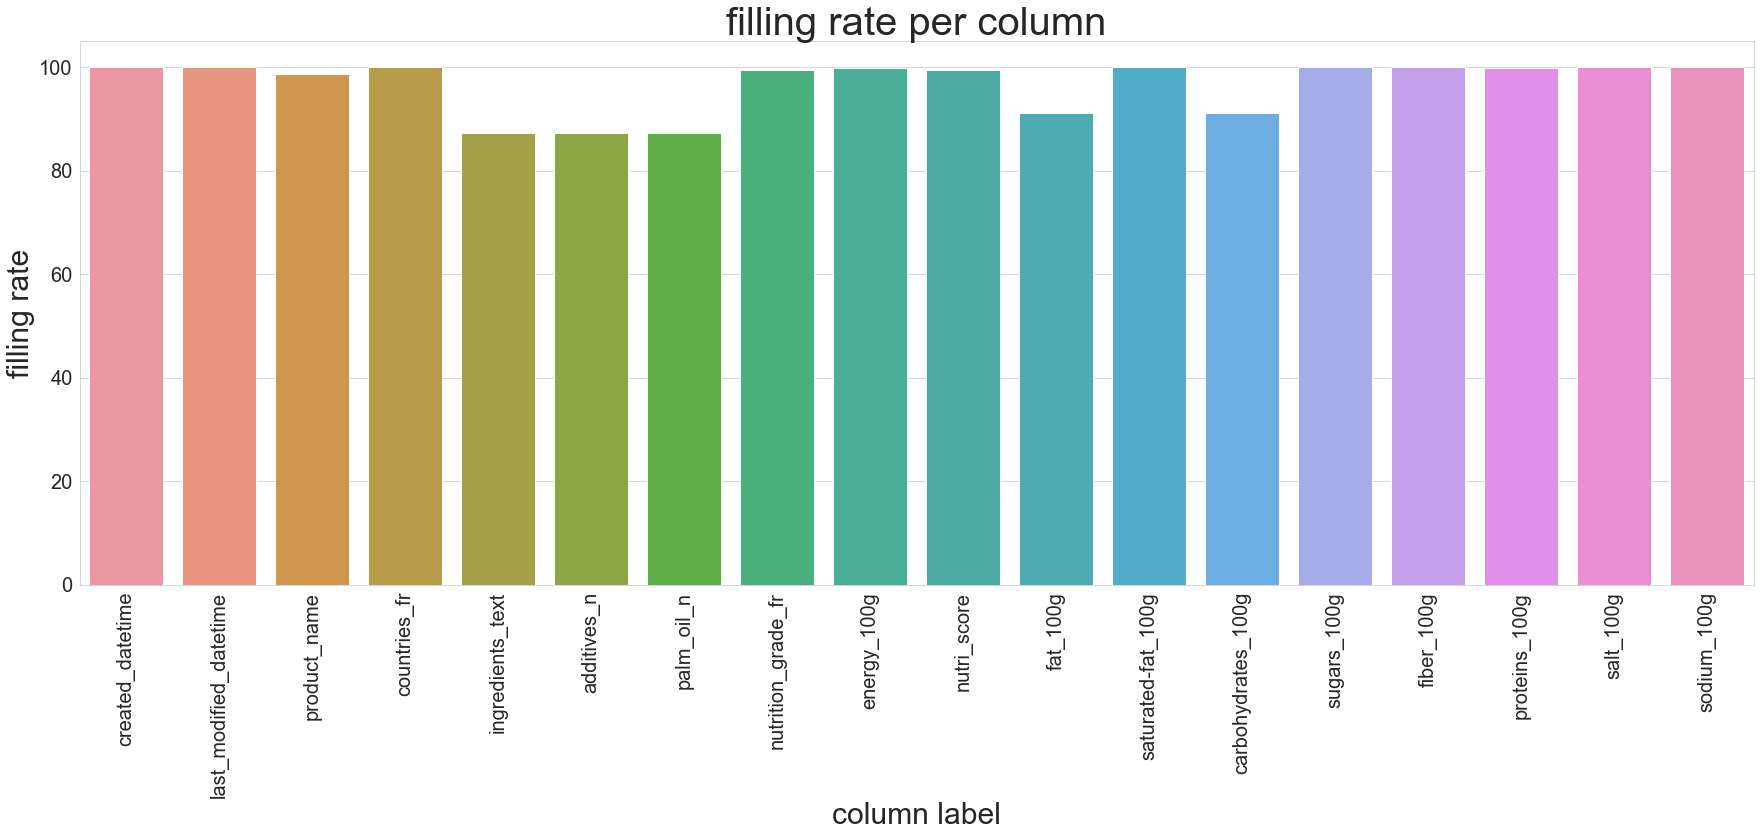

In [58]:
#Simple imputer
simple_imputer=SimpleImputer(strategy='constant',fill_value=0.)
norm_df.loc [: , "fiber_100g"] = simple_imputer.fit_transform(norm_df[["fiber_100g"]] )
plot_filling_rate(norm_df)


(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

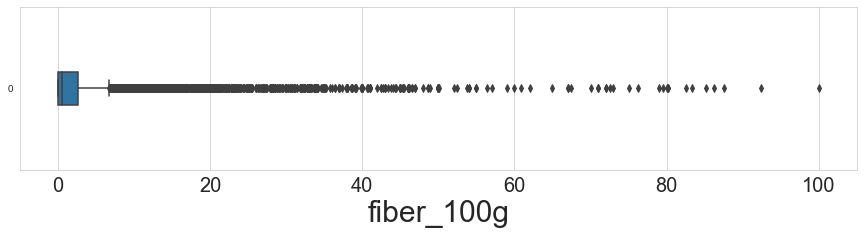

In [59]:
plt.figure(figsize=(15,3))
sns.boxplot(data = norm_df.select_dtypes(include="float64")["fiber_100g"], orient="h", width=0.2)
plt.xlabel("fiber_100g", size=30)
plt.xticks(size=20)



In [60]:
#Create dataframe with correlated features
corr_data = norm_df.filter(items = ['fat_100g', 'saturated-fat_100g','energy_100g','nutri_score'] , axis = 1)
#Iterative Imputer

iter_imputer=IterativeImputer(missing_values=np.nan,random_state=0,max_iter=150)
corr_data=pd.DataFrame (iter_imputer.fit_transform(corr_data))

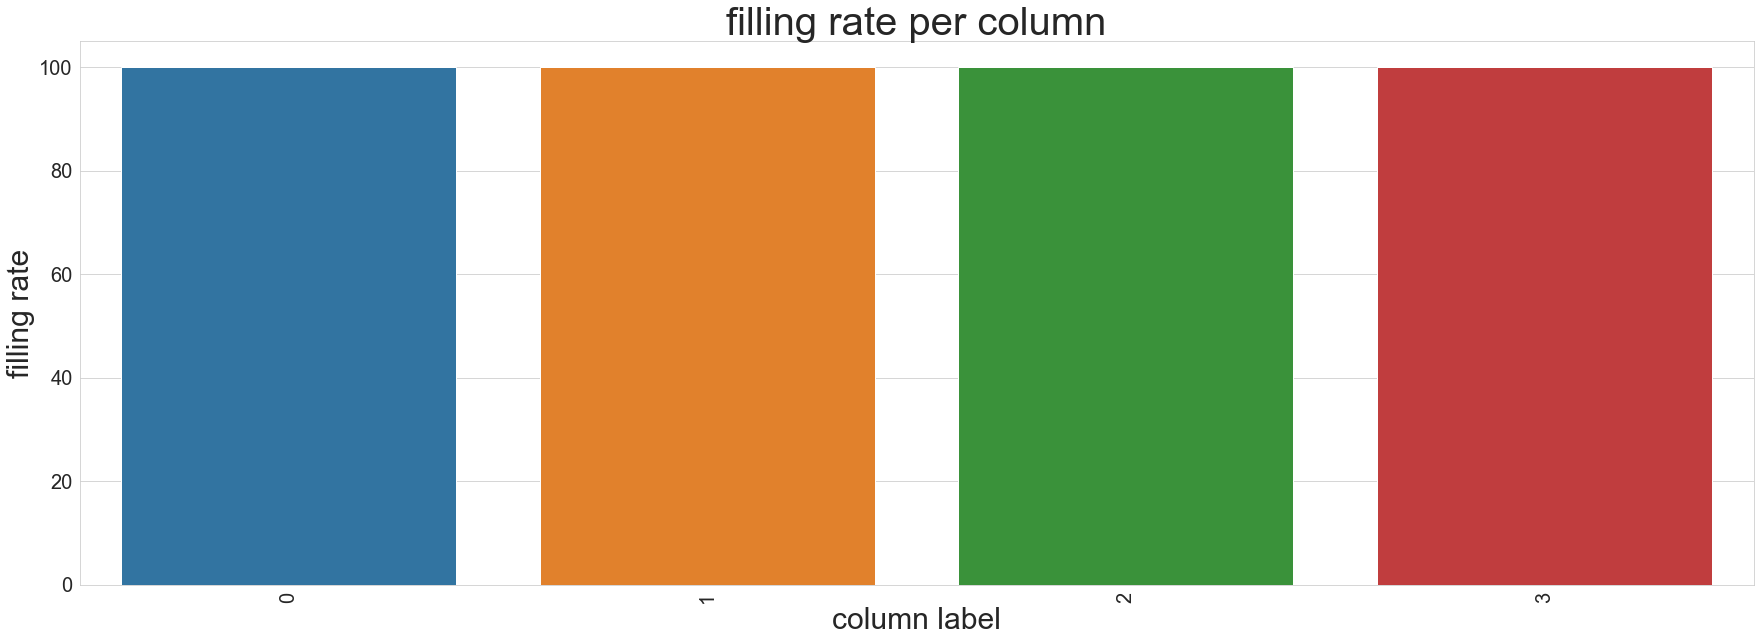

In [61]:
plot_filling_rate(corr_data)                                    

In [62]:
corr_data.rename({0:'fat_100g', 1:'saturated-fat_100g' , 2:'energy_100g' , 3:'nutri_score'} , axis = 1 , inplace=True )

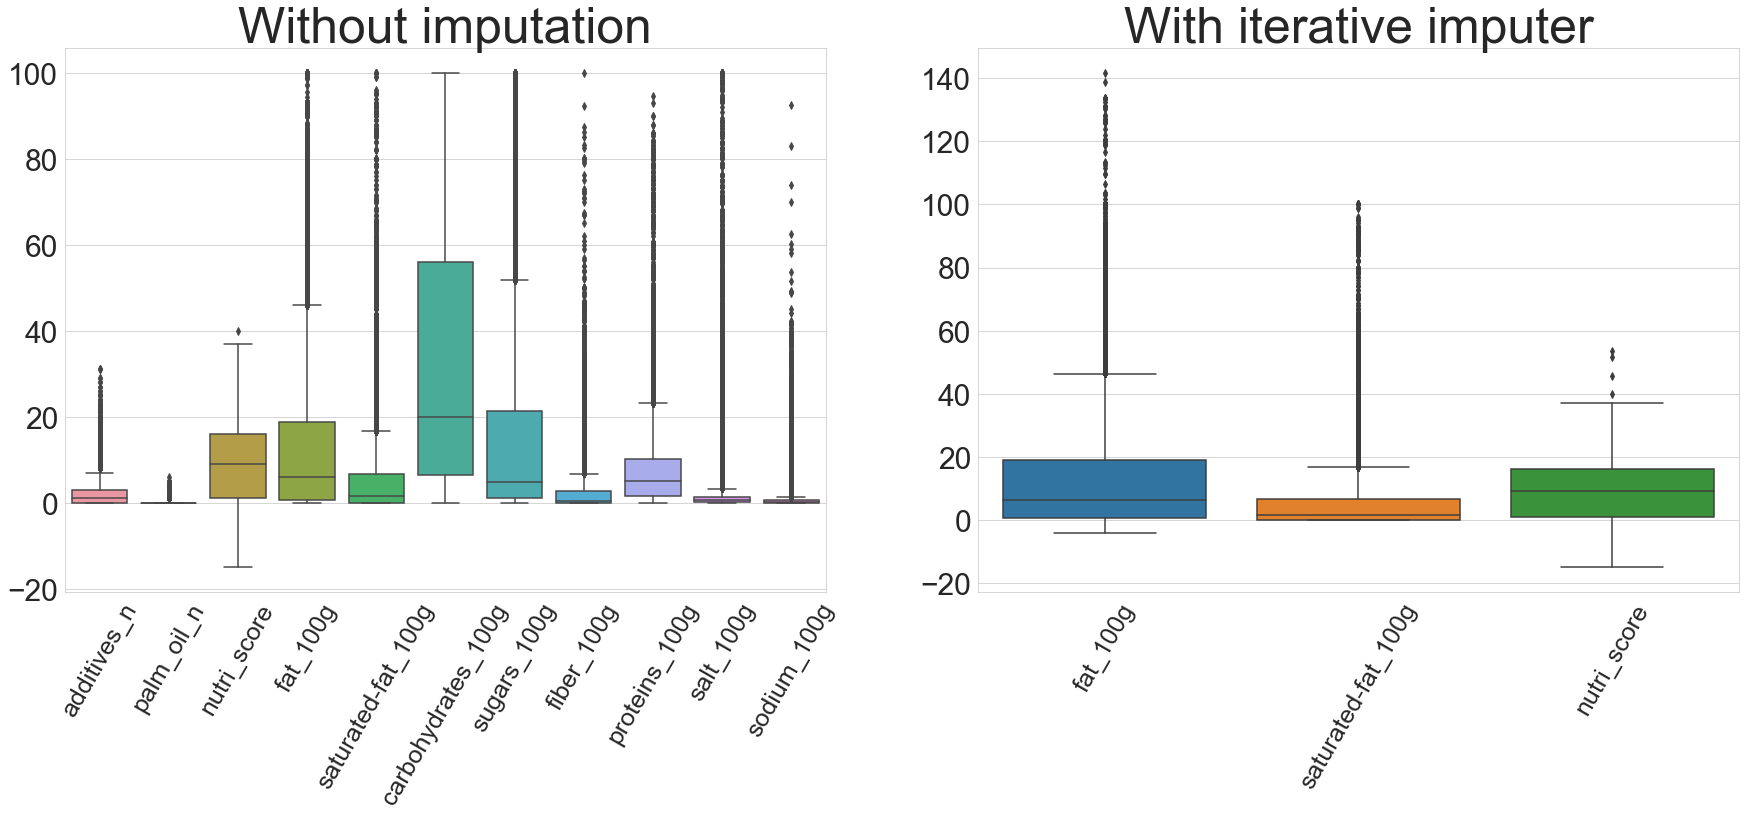

In [63]:
plt.subplot(1,2,1)
sns.boxplot(data = norm_df.select_dtypes(include="float64").drop (["energy_100g"] , axis=1))
plt.xticks(size=30)
plt.xticks(size=25 , rotation = 60)
plt.yticks(size=30)
plt.title ("Without imputation" , size = 50)

plt.subplot(1,2,2)
sns.boxplot(data = corr_data.drop (["energy_100g"] , axis=1))
plt.xticks(size=25 , rotation = 60)
plt.yticks(size=30)
plt.title ("With iterative imputer" ,  size = 50)


plt.savefig("boxplot iter imputer.png")


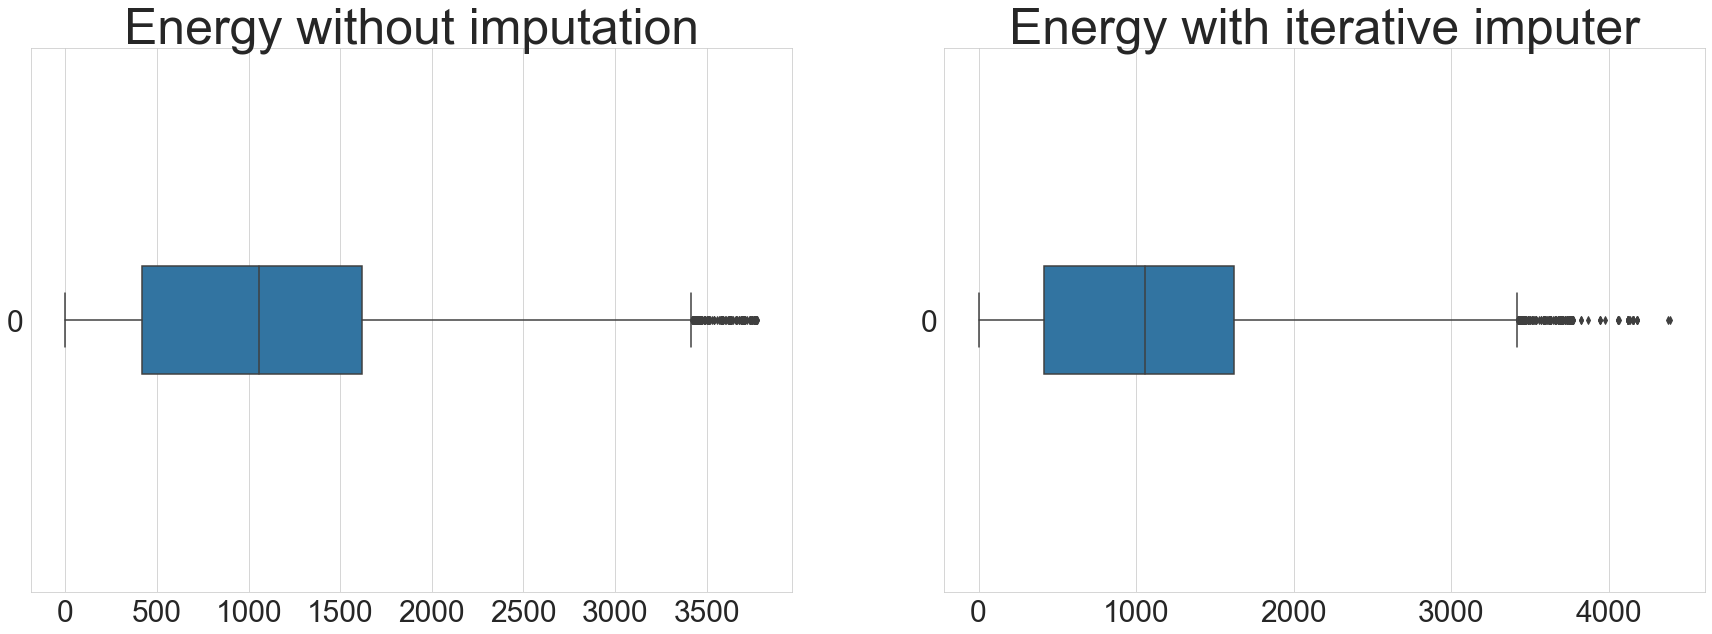

In [64]:
plt.subplot(1,2,1)
sns.boxplot(data = norm_df ["energy_100g"], orient="h",width = 0.2)
plt.yticks(size=30)
plt.xticks(size=30)
plt.title ("Energy without imputation" , size = 50)

plt.subplot(1,2,2)
sns.boxplot(data = corr_data ["energy_100g"], orient="h" , width = 0.2)
plt.yticks(size=30)
plt.xticks(size=30)
plt.title ("Energy with iterative imputer" ,  size = 50  )

plt.savefig("energy boxplot iter imputer.png")

In [65]:
norm_df.isna().sum()

created_datetime          1    
last_modified_datetime    0    
product_name              2647 
countries_fr              52   
ingredients_text          24714
additives_n               24714
palm_oil_n                24714
nutrition_grade_fr        1029 
energy_100g               307  
nutri_score               1029 
fat_100g                  17191
saturated-fat_100g        0    
carbohydrates_100g        17304
sugars_100g               0    
fiber_100g                0    
proteins_100g             504  
salt_100g                 28   
sodium_100g               0    
dtype: int64

In [66]:
kNN_cols = ['additives_n', 'palm_oil_n', 'energy_100g', 'nutri_score',
            'fat_100g','carbohydrates_100g', 'proteins_100g', 'salt_100g']


In [67]:
for col in kNN_cols : 
    knn_imputer = KNNImputer(n_neighbors = 5)
    norm_df.loc[: , col] = knn_imputer.fit_transform (norm_df[[col]])

C:\Users\betas\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\betas\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\betas\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

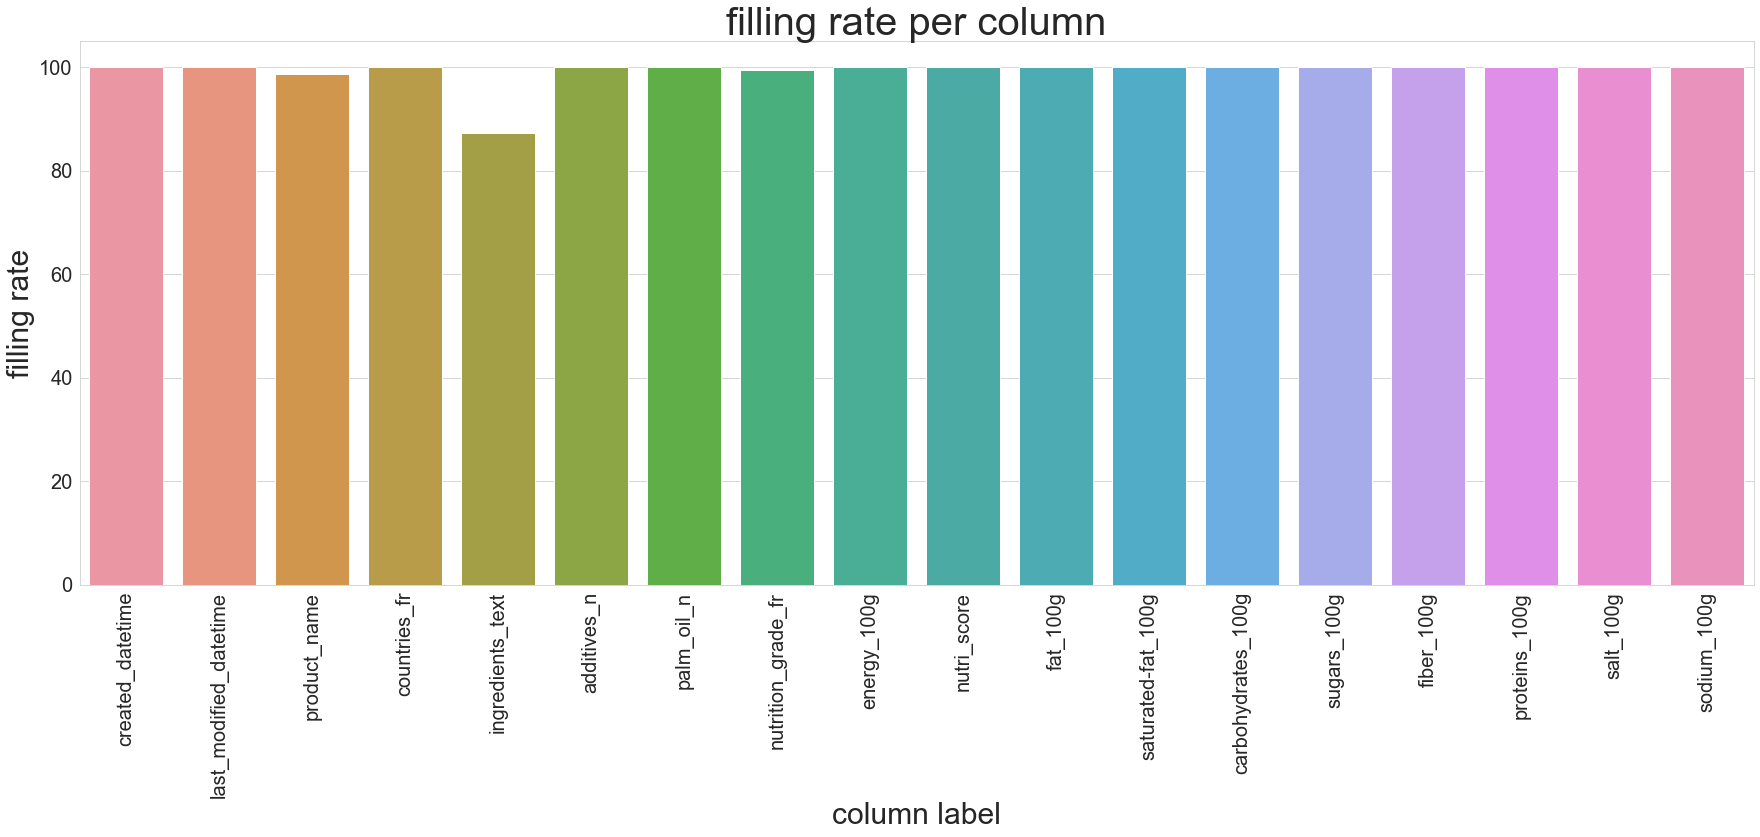

In [68]:
plot_filling_rate(norm_df)  

Text(0.5, 1.0, 'With kNN imputation')

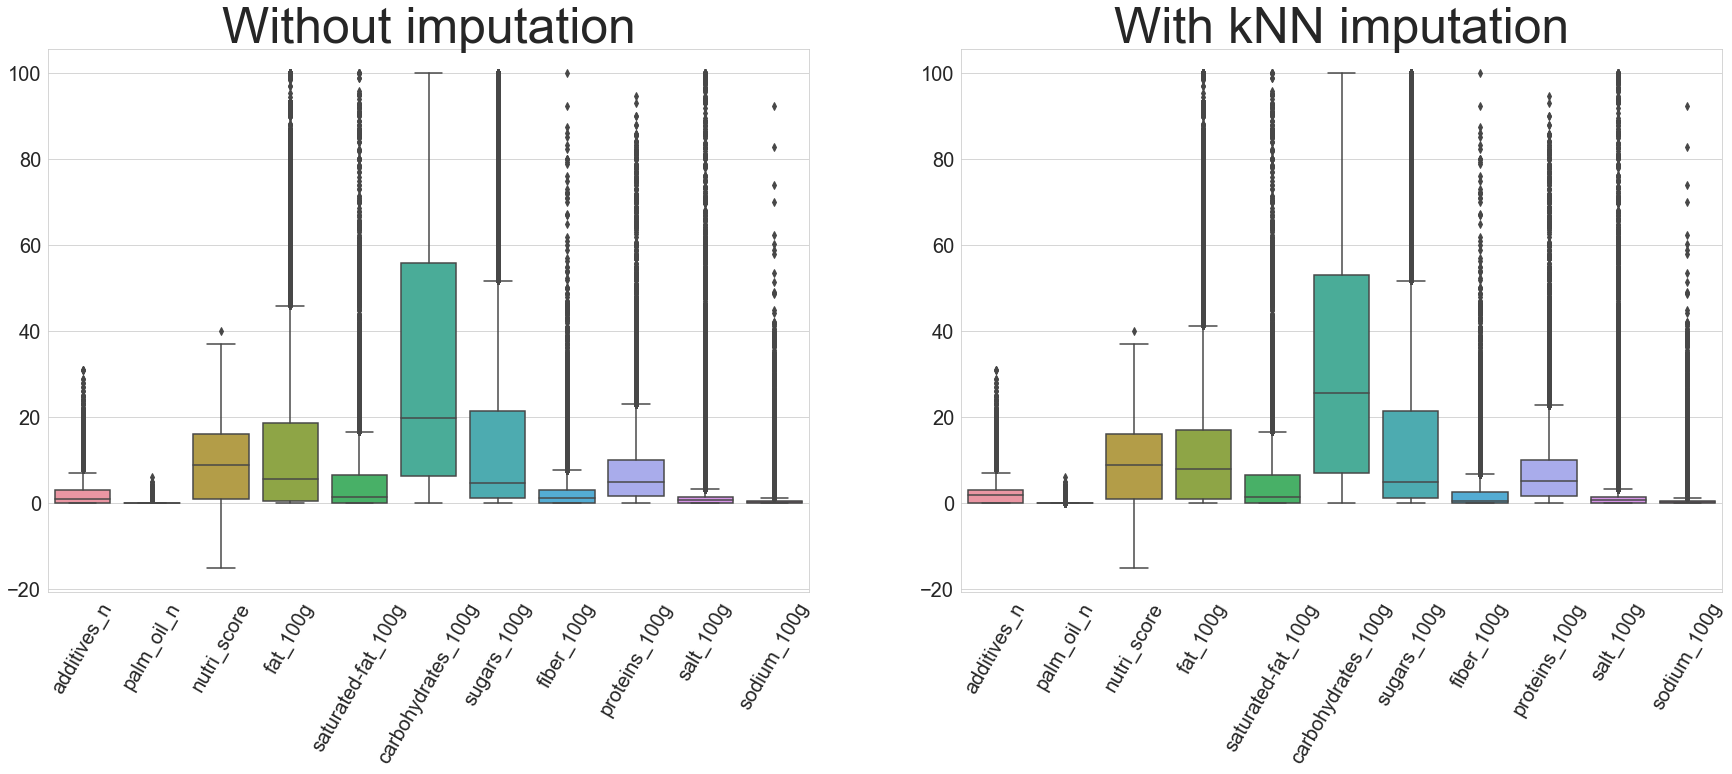

In [69]:
plt.subplot(1,2,1)
sns.boxplot(data = numeric_data.drop (["energy_100g"] , axis=1))
plt.xticks(size=20)
plt.xticks(size=20 , rotation = 60)
plt.yticks(size=20)
plt.title ("Without imputation" , size = 50)

plt.subplot(1,2,2)
sns.boxplot(data = norm_df.select_dtypes(include="float64").drop (["energy_100g"] , axis=1))
plt.xticks(size=20 , rotation = 60)
plt.yticks(size=20)
plt.title ("With kNN imputation" , size = 50)



Text(0.5, 1.0, 'Energy with kNN imputation')

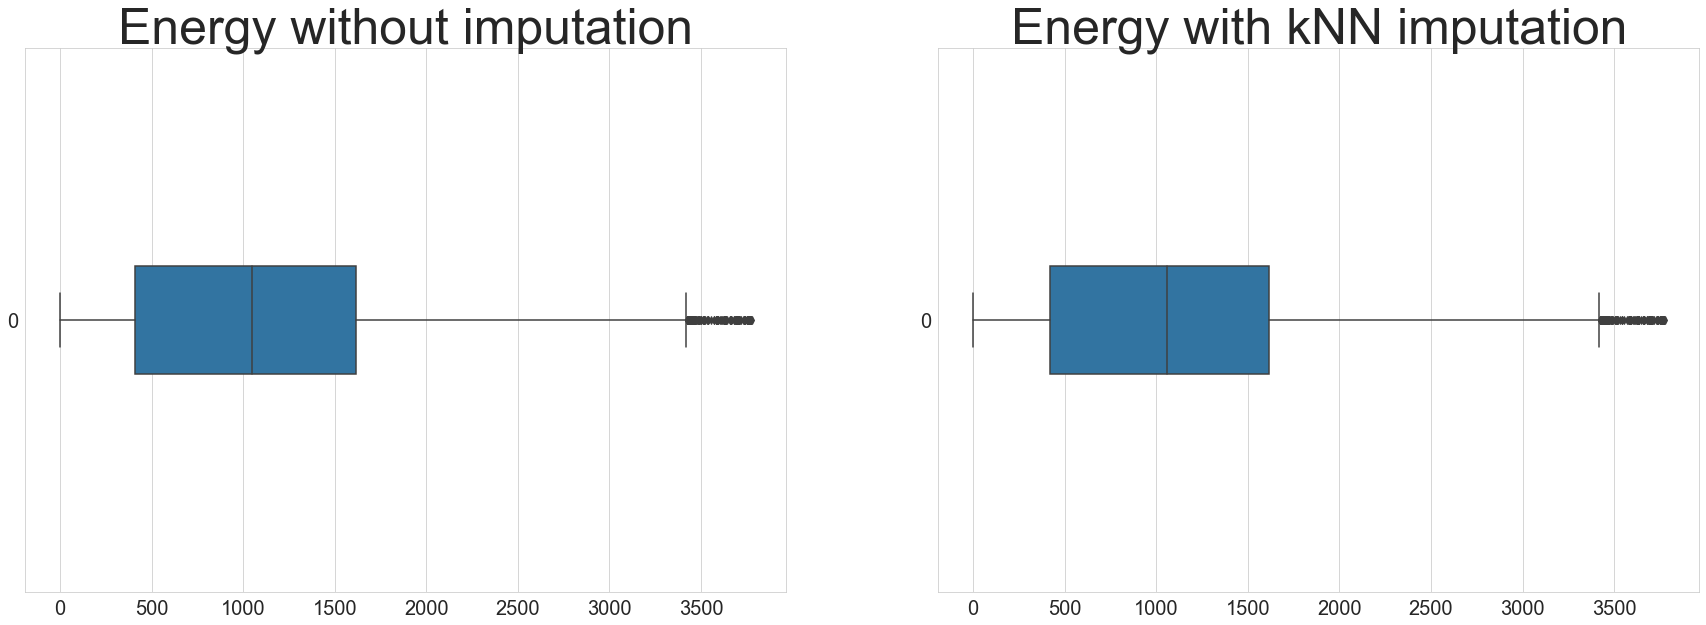

In [70]:
plt.subplot(1,2,1)
sns.boxplot(data = numeric_data ["energy_100g"], orient="h" , width=0.2)
plt.yticks(size=20)
plt.xticks(size=20)
plt.title ("Energy without imputation" , size = 50)

plt.subplot(1,2,2)
sns.boxplot(data = norm_df ["energy_100g"], orient="h", width=0.2)
plt.yticks(size=20)
plt.xticks(size=20)
plt.title ("Energy with kNN imputation" , size = 50)


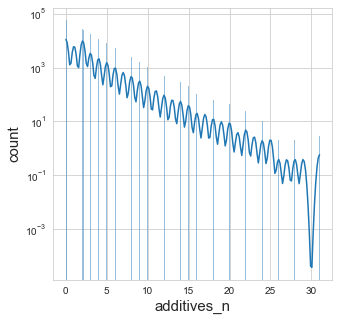

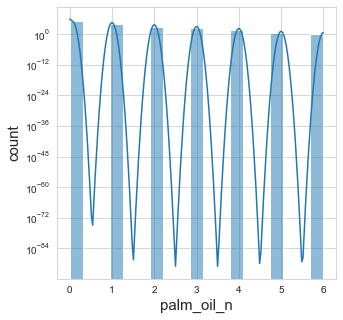

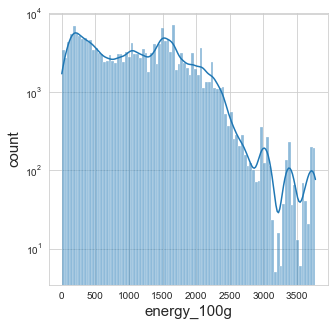

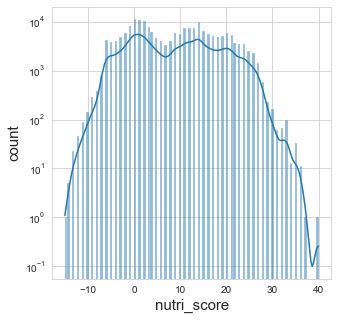

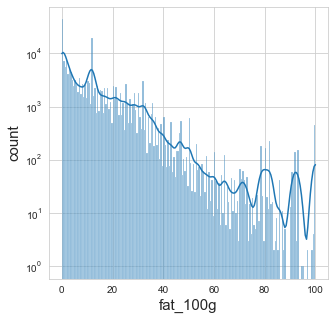

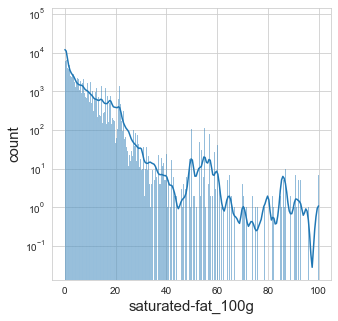

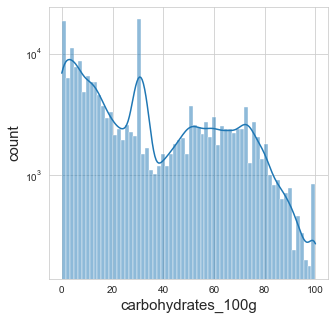

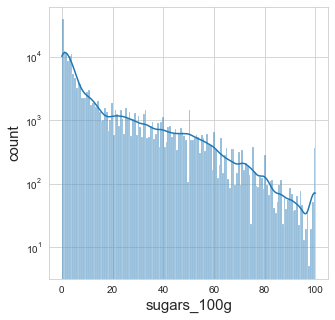

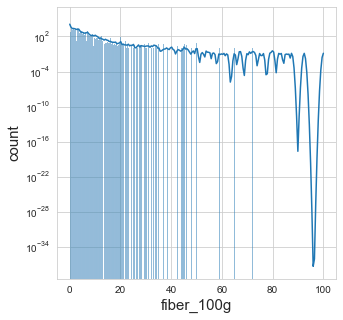

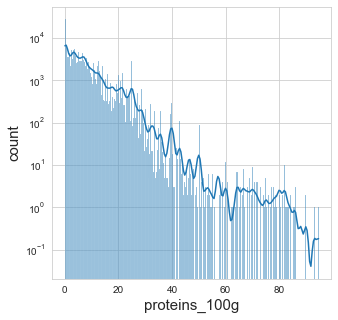

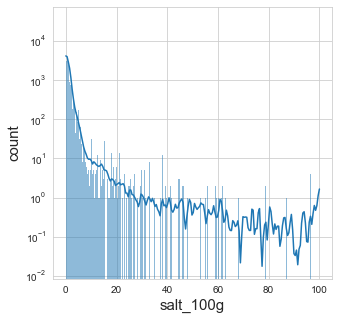

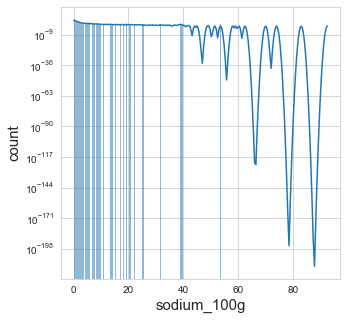

In [71]:
for col in numeric_data.columns :
    plt.figure(figsize=(5,5))
    sns.histplot(norm_df[col] , kde=True )
    plt.yscale ("log")
    plt.xlabel(col, size=15)   
    plt.ylabel("count", size=15)

#### KNN Classiffier for nutrition grade missing values imputation

In [72]:
#Encoding
le=LabelEncoder()
norm_df["nutrition_grade_fr"]=le.fit_transform(norm_df["nutrition_grade_fr"])
norm_df

<ipython-input-72-96c85792456d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  norm_df["nutrition_grade_fr"]=le.fit_transform(norm_df["nutrition_grade_fr"])


,created_datetime,last_modified_datetime,product_name,countries_fr,ingredients_text,additives_n,palm_oil_n,nutrition_grade_fr,energy_100g,nutri_score,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g
0,2017-03-09 10:34:10+00:00,2017-03-09 10:34:11+00:00,zen party mix,États-Unis,"roasted peanuts (peanuts, peanut or canola oil, salt), sesame sticks (unbleached wheat flour, sesame seeds, sunflower oil, sa;t, beet powder, turmeric), chili crackers (rice, corn starch, soy sauce[water, soybeans, wheat, salt], brown rice syrup, paprika, onion powder, garlic powder), tamari roasted almonds (almonds, tamari shoyu [water, wheat, soybeans, salt]), salt",1.0000000,0.00000000,3,2230.0,12.0,36.67000000,5.00,36.67000000,3.33,6.7,16.67,1.60782,0.63300000
1,2017-03-09 10:34:42+00:00,2017-03-09 10:34:42+00:00,organic oat groats,États-Unis,organic oat groats,0.0000000,0.00000000,0,1096.0,-6.0,5.95000000,1.19,66.67000000,2.38,9.5,16.67,0.02540,0.01000000
2,2017-03-09 10:35:06+00:00,2017-03-09 10:35:06+00:00,energy power mix,États-Unis,"yogurt raisins, tamari roasted almonds, organic tamari roasted soy nuts, dark chocolate stars, cranberries, dark chocolate chips, peanut butter chips, milk chocolate raisins, pineapple, papaya, peanut butter peanuts & raisins, roasted peanuts.",0.0000000,0.00000000,3,1464.0,14.0,17.50000000,7.50,42.50000000,32.50,5.0,7.50,0.28448,0.11200000
3,2017-03-09 10:35:21+00:00,2017-03-09 10:35:21+00:00,fire roasted hatch green chile almonds,États-Unis,"dry roasted almonds, hatch green chile seasoning (organic cheddar cheese powder [organic cheddar cheese {cultured pasteurized milk, salt, enzymes}, organic nonfat milk,organic whey, salt, sodium phosphate], salt, hatch green chile pepper, evaporated cane juice, onion, parsely, natural flavors,garlic, maltodextrin, spices, spices extractives, citric acid), expeller pressed canola oil.",2.0000000,0.00000000,3,2372.0,11.0,50.00000000,3.33,23.33000000,6.67,10.0,6.67,1.27000,0.50000000
4,2017-03-10 09:34:46+00:00,2017-03-10 09:34:46+00:00,peanut butter power chews,États-Unis,"peanut butter (dry roasted peanuts, palm oil, salt), honey, crispy brown rice (brown rice flour [rice flour, rice bran], honey, calcium carbonate), barley malt, soy lecithin (an emulsifier), sea salt, locust bean gum, carrageenan gum.",3.0000000,0.00000000,2,1954.0,9.0,20.00000000,2.22,60.00000000,33.33,4.4,8.89,0.19812,0.07800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200457,2017-03-09 20:45:00+00:00,2017-03-09 20:45:00+00:00,natural cassava,États-Unis,cassava.,0.0000000,0.00000000,0,1477.0,-1.0,0.00000000,0.00,87.06000000,2.35,4.7,1.18,0.03048,0.01200000
200458,2015-07-25 09:47:06+00:00,2015-09-14 13:37:28+00:00,tartines craquantes bio au sarrasin,France,NaN,2.1003182,0.06480044,0,1643.0,-4.0,2.80000000,0.60,74.80000000,2.60,5.9,13.00,0.68000,0.26771654
200459,2017-04-01 20:52:18+00:00,2017-04-01 20:52:19+00:00,amandes,France,NaN,2.1003182,0.06480044,1,2406.0,0.0,11.72801709,3.73,30.95487949,3.89,12.2,21.22,0.10000,0.03937008
200460,2013-04-28 15:30:39+00:00,2013-06-20 01:09:16+00:00,thé vert earl grey,France,"thé vert, arôme naturel bergamote avec autres arômes naturels, écorces d'orange douce 3%",0.0000000,0.00000000,2,21.0,2.0,0.20000000,0.20,0.50000000,0.50,0.2,0.50,0.02540,0.01000000


In [73]:
le.classes_

array(['a', 'b', 'c', 'd', 'e', nan], dtype=object)

In [74]:
known_nutri_grade = norm_df [norm_df['nutrition_grade_fr'] != 5]
unknown_nutri_grade = norm_df [norm_df['nutrition_grade_fr'] == 5]

In [75]:
known_nutri_grade.reset_index(drop=True , inplace=True)
known_nutri_grade

,created_datetime,last_modified_datetime,product_name,countries_fr,ingredients_text,additives_n,palm_oil_n,nutrition_grade_fr,energy_100g,nutri_score,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g
0,2017-03-09 10:34:10+00:00,2017-03-09 10:34:11+00:00,zen party mix,États-Unis,"roasted peanuts (peanuts, peanut or canola oil, salt), sesame sticks (unbleached wheat flour, sesame seeds, sunflower oil, sa;t, beet powder, turmeric), chili crackers (rice, corn starch, soy sauce[water, soybeans, wheat, salt], brown rice syrup, paprika, onion powder, garlic powder), tamari roasted almonds (almonds, tamari shoyu [water, wheat, soybeans, salt]), salt",1.0000000,0.00000000,3,2230.0,12.0,36.67000000,5.00,36.67000000,3.33,6.7,16.67,1.60782,0.63300000
1,2017-03-09 10:34:42+00:00,2017-03-09 10:34:42+00:00,organic oat groats,États-Unis,organic oat groats,0.0000000,0.00000000,0,1096.0,-6.0,5.95000000,1.19,66.67000000,2.38,9.5,16.67,0.02540,0.01000000
2,2017-03-09 10:35:06+00:00,2017-03-09 10:35:06+00:00,energy power mix,États-Unis,"yogurt raisins, tamari roasted almonds, organic tamari roasted soy nuts, dark chocolate stars, cranberries, dark chocolate chips, peanut butter chips, milk chocolate raisins, pineapple, papaya, peanut butter peanuts & raisins, roasted peanuts.",0.0000000,0.00000000,3,1464.0,14.0,17.50000000,7.50,42.50000000,32.50,5.0,7.50,0.28448,0.11200000
3,2017-03-09 10:35:21+00:00,2017-03-09 10:35:21+00:00,fire roasted hatch green chile almonds,États-Unis,"dry roasted almonds, hatch green chile seasoning (organic cheddar cheese powder [organic cheddar cheese {cultured pasteurized milk, salt, enzymes}, organic nonfat milk,organic whey, salt, sodium phosphate], salt, hatch green chile pepper, evaporated cane juice, onion, parsely, natural flavors,garlic, maltodextrin, spices, spices extractives, citric acid), expeller pressed canola oil.",2.0000000,0.00000000,3,2372.0,11.0,50.00000000,3.33,23.33000000,6.67,10.0,6.67,1.27000,0.50000000
4,2017-03-10 09:34:46+00:00,2017-03-10 09:34:46+00:00,peanut butter power chews,États-Unis,"peanut butter (dry roasted peanuts, palm oil, salt), honey, crispy brown rice (brown rice flour [rice flour, rice bran], honey, calcium carbonate), barley malt, soy lecithin (an emulsifier), sea salt, locust bean gum, carrageenan gum.",3.0000000,0.00000000,2,1954.0,9.0,20.00000000,2.22,60.00000000,33.33,4.4,8.89,0.19812,0.07800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194327,2017-03-09 20:45:00+00:00,2017-03-09 20:45:00+00:00,natural cassava,États-Unis,cassava.,0.0000000,0.00000000,0,1477.0,-1.0,0.00000000,0.00,87.06000000,2.35,4.7,1.18,0.03048,0.01200000
194328,2015-07-25 09:47:06+00:00,2015-09-14 13:37:28+00:00,tartines craquantes bio au sarrasin,France,NaN,2.1003182,0.06480044,0,1643.0,-4.0,2.80000000,0.60,74.80000000,2.60,5.9,13.00,0.68000,0.26771654
194329,2017-04-01 20:52:18+00:00,2017-04-01 20:52:19+00:00,amandes,France,NaN,2.1003182,0.06480044,1,2406.0,0.0,11.72801709,3.73,30.95487949,3.89,12.2,21.22,0.10000,0.03937008
194330,2013-04-28 15:30:39+00:00,2013-06-20 01:09:16+00:00,thé vert earl grey,France,"thé vert, arôme naturel bergamote avec autres arômes naturels, écorces d'orange douce 3%",0.0000000,0.00000000,2,21.0,2.0,0.20000000,0.20,0.50000000,0.50,0.2,0.50,0.02540,0.01000000


In [76]:
unknown_nutri_grade.reset_index(drop=True , inplace=True)
unknown_nutri_grade

,created_datetime,last_modified_datetime,product_name,countries_fr,ingredients_text,additives_n,palm_oil_n,nutrition_grade_fr,energy_100g,nutri_score,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g
0,2015-04-27 21:06:59+00:00,2015-08-09 17:35:55+00:00,balsamic vinegar of modena,France,"vinaigre de vin, moult de raisin concentré, colorant e150d, antioxygène: sulfites (e224)",2.0,0.0,5,63.00000000,8.8495976,0.00,0.00,30.95487949,3.00,0.0,7.33001392,0.00000,0.000
1,2017-03-09 13:21:48+00:00,2017-03-09 13:21:49+00:00,yeast raised glazed donuts,États-Unis,"enriched flour (wheat flour, barley malt, niacin, reduced iron, thiamine mononitrate, riboflavin folic acid), water, palm oil, yeast, sugar, soybean oil, contains less than 2% of salt, soy flour, emulsifiers (glycerin, sodium stearoyl lactylate), enzymes, dextrose calcium sulfate, egg, milk, ascorbic acid, maltodextrin, acacia gum, medium chain triglycerides, beta carotene (for color). glaze also contains: corn syrup, corn starch, calcium carbonate, agar, natural and artificial flavor (contains milk), sorbitan monosterate, mono & diglycerides.",9.0,1.0,5,1828.00000000,8.8495976,26.76,12.68,45.07000000,15.49,1.4,7.33001392,0.89408,0.352
2,2017-03-09 13:04:33+00:00,2017-03-09 13:04:33+00:00,sharp cheddar,États-Unis,"pasteurized milk, cheese culture, salt, enzymes, annatto (for color).",1.0,0.0,5,1086.91368999,8.8495976,32.14,17.86,3.57000000,0.00,0.0,25.00000000,1.63322,0.643
3,2017-03-09 16:44:00+00:00,2017-03-09 16:44:00+00:00,bfg cornbread,États-Unis,"enriched flour (wheat flour, niacin, iron, thiamin mononitrate, riboflavin, folic acid, malt), sugar, water, eggs, degermed cornmeal, soybean/canola oil, dextrose, milk whey, modified corn starch, corn syrup, leavening (sodium acid pyrophosphate, sodium a",3.0,0.0,5,1251.00000000,8.8495976,11.94,1.49,41.79000000,19.40,1.5,7.33001392,0.83312,0.328
4,2017-03-09 12:20:15+00:00,2017-03-09 12:20:15+00:00,maple & brown sugar instant oatmeal,États-Unis,"rolled oats, sugar, salt, natural flavor, brown sugar, calcium carbonate, caramel color, artificial flavor, ferric orthophosphate, vitamin a palmitate, niacinamide, acesulfame potassium, thiamine mononitrate, riboflavin, pyridoxine hydrochloride, folic acid, maltitol, neotame.",6.0,0.0,5,1648.00000000,8.8495976,6.06,0.00,72.73000000,15.15,9.1,7.33001392,1.61544,0.636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1024,2016-04-28 09:37:14+00:00,2016-05-08 04:35:50+00:00,english breakfast marmalade,Australie,"sugar, oranges (47%) [juice & peel (contain preservative (223))], glucose syrup, gelling agent (pectin), grapefruit extract.",1.0,0.0,5,1150.00000000,8.8495976,0.10,0.00,67.00000000,63.50,0.0,7.33001392,0.02540,0.010
1025,2013-06-06 19:07:53+00:00,2017-02-16 14:45:30+00:00,nouilles orientales arôme de boeuf 85 g - mamee,"France,Suisse","ingrédients nouilles : farine de froment, huile de palme, sel, stabilisants : polyphosphate (e452), carbonate de potassium (e501). ingrédients sachet d'assaisonnement : sel, exhausteur de saveur : glutamate monosodique (e621), arôme de bœuf, sucre, ail en poudre, poivre en poudre, épices en poudre, ciboulette sèche.",3.0,0.0,5,1848.00000000,8.8495976,18.60,9.30,51.90000000,10.20,10.6,10.00000000,3.06324,1.206
1026,2014-01-24 16:19:09+00:00,2017-02-07 20:31:02+00:00,nouilles orientales arôme de poulet - 85 g - mamee,"France,Suisse","ingrédients nouilles : farine de froment, huile de palme, sel, stabilisants : polyphosphate (e452), carbonate de potassium e501. ingrédients sachet d'assaisonnement : sel, exhausteur de saveur : glutamate monosodique (e621), arôme de poulet, sucre, ail en poudre, poivre en poudre, ciboulette sèche.",3.0,0.0,5,1806.00000000,8.8495976,17.90,8.90,54.00000000,8.30,7.0,10.20000000,3.94970,1.555
1027,2014-01-24 16:31:40+00:00,2017-02-16 14:45:30+00:00,nouilles orientales au curry - 85 g - mamee,"France,Suisse","ingrédients nouilles : farine de fro

In [77]:
X = known_nutri_grade.select_dtypes(include="float64")
y = known_nutri_grade['nutrition_grade_fr']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8 , random_state = 1)
X_test

,additives_n,palm_oil_n,energy_100g,nutri_score,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g
9894,5.0,0.0,1402.0,14.0,0.00,0.00,80.00,62.50,0.0,5.00,0.12700,0.05000000
83121,8.0,0.0,222.0,0.0,0.00,0.00,10.00,7.06,0.0,2.94,0.12700,0.05000000
47732,9.0,0.0,1255.0,12.0,30.00,6.67,6.67,3.33,3.3,3.33,1.60782,0.63300000
192902,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00000,0.00000000
170317,2.0,0.0,335.0,4.0,5.77,2.56,5.13,2.88,1.3,1.28,0.80518,0.31700000
...,...,...,...,...,...,...,...,...,...,...,...,...
153861,12.0,0.0,1115.0,15.0,12.70,6.70,25.00,5.50,2.8,11.60,1.85000,0.72834646
121936,1.0,0.0,1704.0,15.0,41.00,27.50,2.50,2.50,0.0,8.50,1.30000,0.51181102
9023,3.0,0.0,259.0,0.0,0.00,0.00,16.41,13.28,1.6,0.00,0.01016,0.00400000
45137,3.0,0.0,1833.0,17.0,12.50,4.69,78.12,37.50,3.1,3.12,0.95250,0.37500000


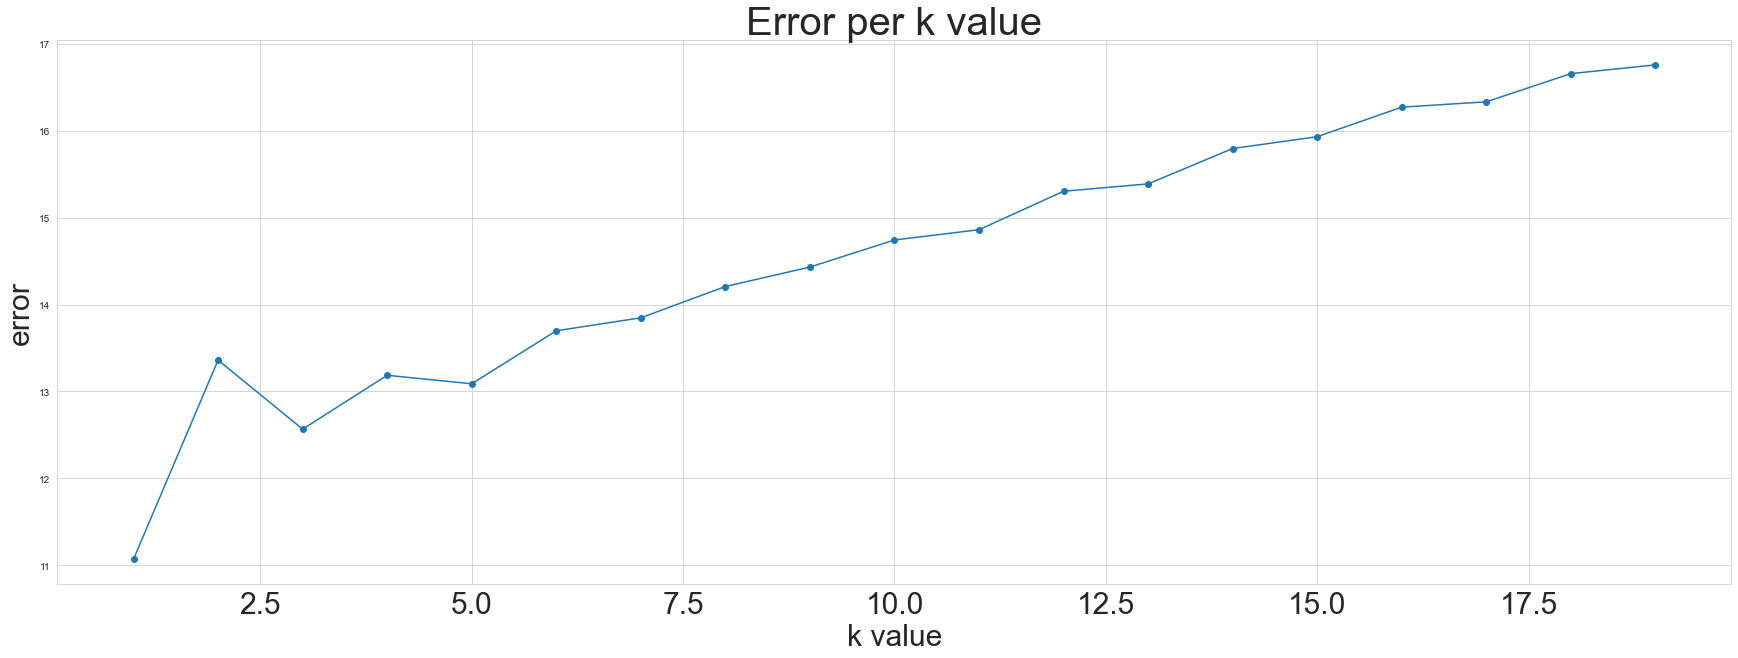

In [78]:
errors = []
for k in range(1,20):
    kNN = KNeighborsClassifier(k)
    errors.append(100*(1 - kNN.fit(X_train, y_train).score(X_test, y_test)))
plt.plot(range(1,20), errors, 'o-')
plt.title ("Error per k value" , size = 40)
plt.xlabel ("k value" , size = 30)
plt.ylabel ("error" , size = 30)
plt.xticks (size = 30)
plt.show()

# We will pick out k = 1 for nutrition grade kNN imputation

In [79]:
kNN = KNeighborsClassifier(n_neighbors = 1)
train_model = kNN.fit(X_train, y_train)
train_model

KNeighborsClassifier(n_neighbors=1)

In [80]:
y_pred = kNN.predict(X_test)

In [81]:
y_pred

array([3, 1, 3, ..., 1, 3, 3])

In [82]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      6539
           1       0.84      0.86      0.85      6360
           2       0.87      0.85      0.86      8009
           3       0.89      0.91      0.90     10690
           4       0.93      0.92      0.92      7269

    accuracy                           0.89     38867
   macro avg       0.89      0.89      0.89     38867
weighted avg       0.89      0.89      0.89     38867



Text(0.5, 1.0, 'heatmap confusion matrix')

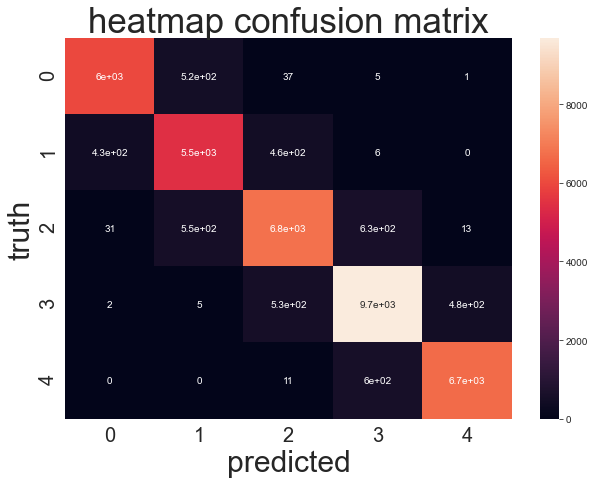

In [83]:
cm = confusion_matrix(y_test,y_pred)
plt.figure (figsize=(10,7))
sns.heatmap (cm , annot=True)
plt.xlabel ("predicted" , size = 30)
plt.xticks (size = 20)
plt.ylabel ("truth" , size = 30)
plt.yticks (size = 20)
plt.title ("heatmap confusion matrix", size = 35)

In [84]:
unknown_nutri_grade.columns

Index(['created_datetime', 'last_modified_datetime', 'product_name',
       'countries_fr', 'ingredients_text', 'additives_n', 'palm_oil_n',
       'nutrition_grade_fr', 'energy_100g', 'nutri_score', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g'],
      dtype='object')

In [85]:
features=['additives_n', 'palm_oil_n', 'energy_100g',
         'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
         'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g',
         'sodium_100g', 'nutrition_grade_fr']

imputed_values=kNN.predict(unknown_nutri_grade[features].values.reshape(-1,12))

In [86]:
imputed_values = pd.DataFrame ({"nutrition_grade" : imputed_values })
imputed_values

,nutrition_grade
0,0
1,4
2,3
3,3
4,3
...,...
1024,3
1025,4
1026,3
1027,3


In [87]:
imputed_data = pd.concat ([unknown_nutri_grade , imputed_values] , axis=1 )

In [88]:
imputed_data.drop (columns=["nutrition_grade_fr"] , axis=1 , inplace=True)


In [89]:
known_nutri_grade.rename (columns={"nutrition_grade_fr" : "nutrition_grade"} , inplace=True)

C:\Users\betas\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [90]:
imputed_data = imputed_data[['created_datetime', 'last_modified_datetime', 'product_name',
       'countries_fr', 'ingredients_text', 'additives_n', 'palm_oil_n',"nutrition_grade",
       'energy_100g', 'nutri_score', 'fat_100g', 'saturated-fat_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'sodium_100g']]

In [101]:
final_data=pd.concat([known_nutri_grade,imputed_data])
final_data["nutrition_grade"]=le.inverse_transform(final_data["nutrition_grade"])
final_data


,created_datetime,last_modified_datetime,product_name,countries_fr,ingredients_text,additives_n,palm_oil_n,nutrition_grade,energy_100g,nutri_score,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g
0,2017-03-09 10:34:10+00:00,2017-03-09 10:34:11+00:00,zen party mix,États-Unis,"roasted peanuts (peanuts, peanut or canola oil, salt), sesame sticks (unbleached wheat flour, sesame seeds, sunflower oil, sa;t, beet powder, turmeric), chili crackers (rice, corn starch, soy sauce[water, soybeans, wheat, salt], brown rice syrup, paprika, onion powder, garlic powder), tamari roasted almonds (almonds, tamari shoyu [water, wheat, soybeans, salt]), salt",1.0,0.0,d,2230.0,12.0000000,36.67,5.00,36.67,3.33,6.7,16.67000000,1.60782,0.633
1,2017-03-09 10:34:42+00:00,2017-03-09 10:34:42+00:00,organic oat groats,États-Unis,organic oat groats,0.0,0.0,a,1096.0,-6.0000000,5.95,1.19,66.67,2.38,9.5,16.67000000,0.02540,0.010
2,2017-03-09 10:35:06+00:00,2017-03-09 10:35:06+00:00,energy power mix,États-Unis,"yogurt raisins, tamari roasted almonds, organic tamari roasted soy nuts, dark chocolate stars, cranberries, dark chocolate chips, peanut butter chips, milk chocolate raisins, pineapple, papaya, peanut butter peanuts & raisins, roasted peanuts.",0.0,0.0,d,1464.0,14.0000000,17.50,7.50,42.50,32.50,5.0,7.50000000,0.28448,0.112
3,2017-03-09 10:35:21+00:00,2017-03-09 10:35:21+00:00,fire roasted hatch green chile almonds,États-Unis,"dry roasted almonds, hatch green chile seasoning (organic cheddar cheese powder [organic cheddar cheese {cultured pasteurized milk, salt, enzymes}, organic nonfat milk,organic whey, salt, sodium phosphate], salt, hatch green chile pepper, evaporated cane juice, onion, parsely, natural flavors,garlic, maltodextrin, spices, spices extractives, citric acid), expeller pressed canola oil.",2.0,0.0,d,2372.0,11.0000000,50.00,3.33,23.33,6.67,10.0,6.67000000,1.27000,0.500
4,2017-03-10 09:34:46+00:00,2017-03-10 09:34:46+00:00,peanut butter power chews,États-Unis,"peanut butter (dry roasted peanuts, palm oil, salt), honey, crispy brown rice (brown rice flour [rice flour, rice bran], honey, calcium carbonate), barley malt, soy lecithin (an emulsifier), sea salt, locust bean gum, carrageenan gum.",3.0,0.0,c,1954.0,9.0000000,20.00,2.22,60.00,33.33,4.4,8.89000000,0.19812,0.078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1024,2016-04-28 09:37:14+00:00,2016-05-08 04:35:50+00:00,english breakfast marmalade,Australie,"sugar, oranges (47%) [juice & peel (contain preservative (223))], glucose syrup, gelling agent (pectin), grapefruit extract.",1.0,0.0,d,1150.0,8.8495976,0.10,0.00,67.00,63.50,0.0,7.33001392,0.02540,0.010
1025,2013-06-06 19:07:53+00:00,2017-02-16 14:45:30+00:00,nouilles orientales arôme de boeuf 85 g - mamee,"France,Suisse","ingrédients nouilles : farine de froment, huile de palme, sel, stabilisants : polyphosphate (e452), carbonate de potassium (e501). ingrédients sachet d'assaisonnement : sel, exhausteur de saveur : glutamate monosodique (e621), arôme de bœuf, sucre, ail en poudre, poivre en poudre, épices en poudre, ciboulette sèche.",3.0,0.0,e,1848.0,8.8495976,18.60,9.30,51.90,10.20,10.6,10.00000000,3.06324,1.206
1026,2014-01-24 16:19:09+00:00,2017-02-07 20:31:02+00:00,nouilles orientales arôme de poulet - 85 g - mamee,"France,Suisse","ingrédients nouilles : farine de froment, huile de palme, sel, stabilisants : polyphosphate (e452), carbonate de potassium e501. ingrédients sachet d'assaisonnement : sel, exhausteur de saveur : glutamate monosodique (e621), arôme de poulet, sucre, ail en poudre, poivre en poudre, ciboulette sèche.",3.0,0.0,d,1806.0,8.8495976,17.90,8.90,54.00,8.30,7.0,10.20000000,3.94970,1.555
1027,2014-01-24 16:31:40+00:00,2017-02-16 14:45:30+00:00,nouilles orientales au curry - 85 g - mamee,"France,Suisse","ingrédients nouilles : farine de froment, huile de palme, sel, stabilisants : polyphosphate (e452), carbonate de potassium e5

In [102]:
select_100g_cols (final_data)

,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g
0,36.67,5.00,36.67,3.33,6.7,16.67000000,1.60782,0.633
1,5.95,1.19,66.67,2.38,9.5,16.67000000,0.02540,0.010
2,17.50,7.50,42.50,32.50,5.0,7.50000000,0.28448,0.112
3,50.00,3.33,23.33,6.67,10.0,6.67000000,1.27000,0.500
4,20.00,2.22,60.00,33.33,4.4,8.89000000,0.19812,0.078
...,...,...,...,...,...,...,...,...
1024,0.10,0.00,67.00,63.50,0.0,7.33001392,0.02540,0.010
1025,18.60,9.30,51.90,10.20,10.6,10.00000000,3.06324,1.206
1026,17.90,8.90,54.00,8.30,7.0,10.20000000,3.94970,1.555
1027,19.20,10.00,49.40,8.20,11.8,9.60000000,3.16230,1.245


In [103]:
final_data["sum_100g"] = select_100g_cols (final_data).sum(axis=1)-(final_data["saturated-fat_100g"] + 
                                                 final_data["sugars_100g"] + final_data["sodium_100g"])
final_data["sum_100g"].max()


142.6828965803213

In [107]:
final_data = final_data [final_data["sum_100g"] < 100]

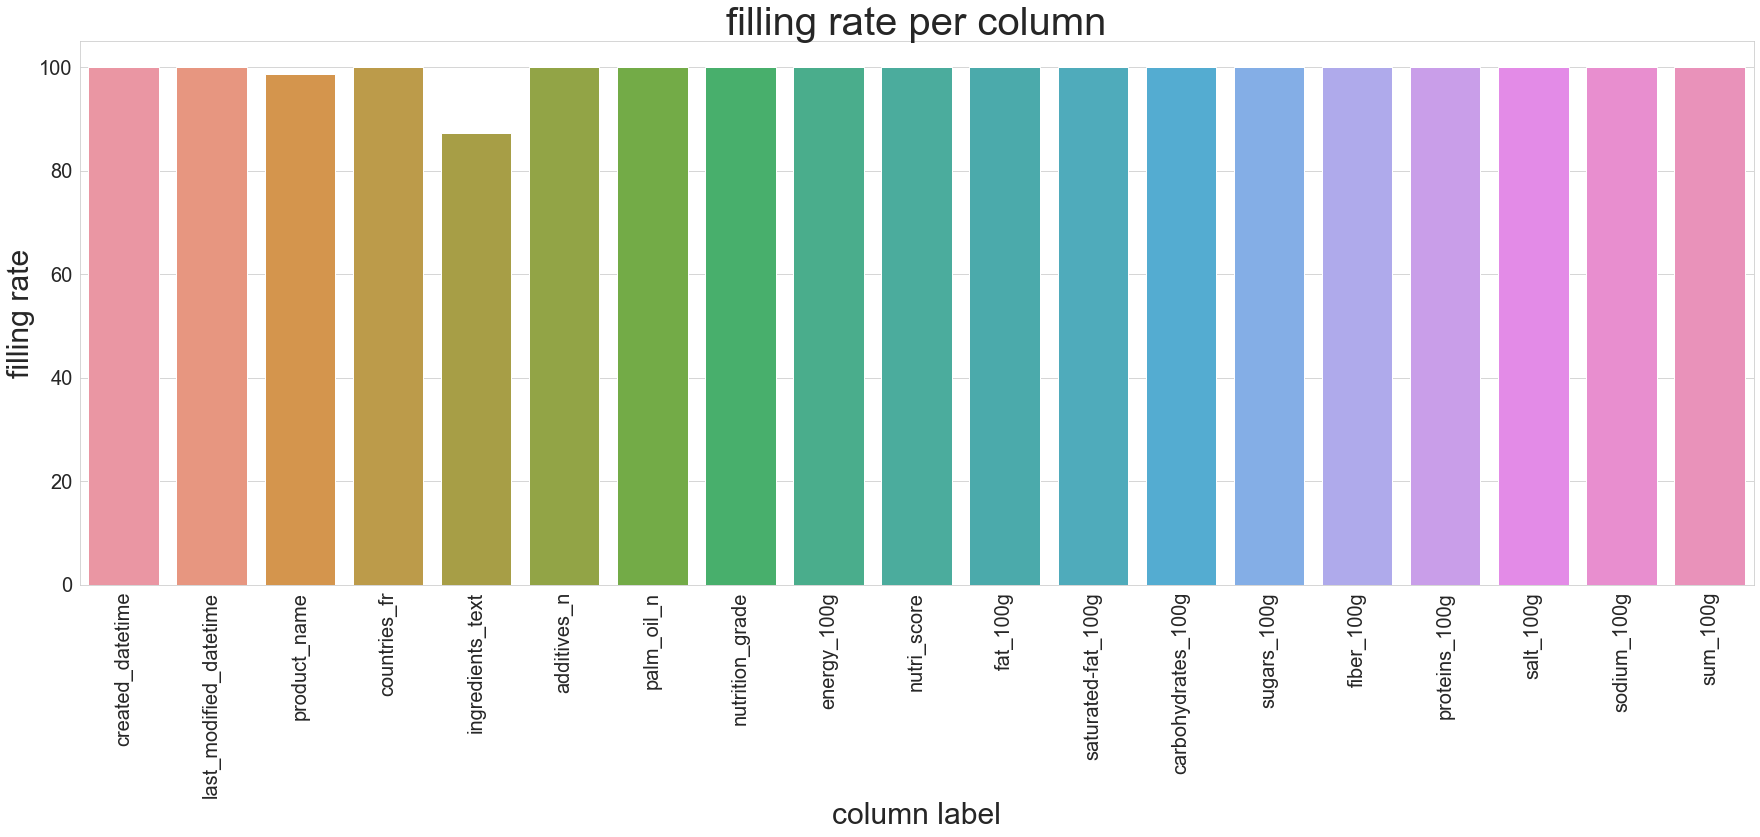

In [108]:
plot_filling_rate (final_data)

In [109]:
final_data.describe()

,additives_n,palm_oil_n,energy_100g,nutri_score,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,sum_100g
count,193708.00000000,193708.00000000,193708.00000000,193708.00000000,193708.00000000,193708.00000000,193708.00000000,193708.00000000,193708.00000000,193708.00000000,193708.00000000,193708.00000000,193708.00000000
mean,2.10413970,0.06522135,1078.95511178,8.82322057,11.55923694,4.62029348,30.71804584,14.21905813,1.82005794,7.34004470,1.23674523,0.49422356,52.67413065
std,2.43232858,0.27417973,712.58857344,9.03910577,13.60383387,7.15724701,26.31123933,19.03059264,3.02431134,7.69584775,3.80565803,1.62581193,30.65273981
min,0.00000000,0.00000000,0.00000000,-15.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
25%,0.00000000,0.00000000,418.00000000,1.00000000,1.00000000,0.00000000,7.02000000,1.19000000,0.00000000,1.61000000,0.10000000,0.03940000,25.00000000
50%,2.00000000,0.00000000,1046.00000000,9.00000000,7.84000000,1.50000000,25.10000000,4.80000000,0.60000000,5.20000000,0.66000000,0.25984252,49.68289658
75%,3.00000000,0.00000000,1611.00000000,16.00000000,17.00000000,6.67000000,52.80000000,21.33000000,2.70000000,10.20000000,1.38430000,0.54525000,85.00000000
max,31.00000000,6.00000000,3776.00000000,40.00000000,100.00000000,100.00000000,100.00000000,100.00000000,87.50000000,90.00000000,99.93000000,92.50000000,100.00000000


In [110]:
final_data.drop("sum_100g", axis=1, inplace=True)

C:\Users\betas\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [111]:
final_data.shape

(193708, 18)

In [112]:
final_data.to_csv("cleaning_OPEN_FOOD_FACTS.csv", sep=',')